In [1]:
import argparse
import os
import sys
file_path = 'C:/Users/dB/deBivort/projects/ALVariability/'
proj_dir = os.path.join(file_path.split('ALVariability')[0], 'ALVariability')
sys.path.append(proj_dir)
import pandas as pd
import pickle
import re
from matplotlib.gridspec import GridSpec
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from PyPDF2 import PdfFileWriter, PdfFileReader
import io
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch
import seaborn as sns
import re
from datetime import datetime

from utils.plot_utils import set_font_sizes
set_font_sizes()

In [2]:
dfpick = pickle.load(open('../run_model/save_sims_sensitivity_sweep/sweep_sens_cols.p', 'rb'))

In [3]:
project_dir = os.path.join(file_path.split('ALVariability')[0], 'ALVariability')
df_neur_ids = pd.read_csv(os.path.join(project_dir, 'connectomics/hemibrain_v1_2/df_neur_ids.csv'), index_col=0)
al_block = pd.read_csv(os.path.join(project_dir, 'connectomics/hemibrain_v1_2/AL_block.csv'), index_col=0)
al_block.columns = al_block.columns.astype(np.int64)
al_block.index = al_block.index.astype(np.int64)
imput_table = pd.read_csv(os.path.join(project_dir, 'odor_imputation/df_odor_door_all_odors_imput_ALS.csv'), index_col=0)

In [4]:
df_neur_ids[df_neur_ids.glom == 'VM2']

,bodyId,type,instance,altype,glom,polarity
2569,2074116622,ORN_VM2,ORN_VM2,ORN,VM2,1.0
2895,727472481,VM2_adPN,VM2_adPN_R,uPN,VM2,1.0
2896,697132371,VM2_adPN,VM2_adPN_R,uPN,VM2,1.0


In [5]:
al_block.iloc[:, [2895, 2896]].sum(0)

727472481    42.0
697132371    10.0
dtype: float64

In [6]:
df_neur_ids[df_neur_ids.glom == 'VA2']

,bodyId,type,instance,altype,glom,polarity
500,2137541564,ORN_VA2,ORN_VA2,ORN,VA2,1.0
501,2107197210,ORN_VA2,ORN_VA2,ORN,VA2,1.0
502,2138232554,ORN_VA2,ORN_VA2,ORN,VA2,1.0
503,2138232459,ORN_VA2,ORN_VA2,ORN,VA2,1.0
504,2136522616,ORN_VA2,ORN_VA2,ORN,VA2,1.0
...,...,...,...,...,...,...
593,2076162300,ORN_VA2,ORN_VA2,ORN,VA2,1.0
594,2230646124,ORN_VA2,ORN_VA2,ORN,VA2,1.0
595,2230646168,ORN_VA2,ORN_VA2,ORN,VA2,1.0
596,2230642295,ORN_VA2,ORN_VA2,ORN,VA2,1.0


In [7]:
df_neur_ids_bhand_orns = df_neur_ids[(df_neur_ids.altype == 'ORN') & (df_neur_ids.glom.isin(['DL1', 'DM1', 'DM2', 'DM3', 'DM4', 'VA2', 'VM2']))]
df_neur_ids_bhand_orns['glom'].value_counts()

VA2    97
DM1    86
DL1    84
DM2    79
DM3    68
DM4    60
VM2     1
Name: glom, dtype: int64

In [8]:
df_neur_ids_bhand_upns = df_neur_ids[(df_neur_ids.altype == 'uPN') & (df_neur_ids.glom.isin(['DL1', 'DM1', 'DM2', 'DM3', 'DM4', 'VA2', 'VM2']))]
df_neur_ids_bhand_upns

,bodyId,type,instance,altype,glom,polarity
2788,1977579449,VA2_adPN,VA2_adPN_R,uPN,VA2,1.0
2790,542634818,DM1_lPN,DM1_lPN_R,uPN,DM1,1.0
2794,1700937093,DL1_adPN,DL1_adPN_R,uPN,DL1,1.0
2795,1700946301,DL1_adPN,DL1_adPN_R,uPN,DL1,1.0
2808,630714299,DM2_lPN,DM2_lPN_R,uPN,DM2,1.0
2809,5901222910,DM2_lPN,DM2_lPN_R,uPN,DM2,1.0
2813,755518957,DM3_adPN,DM3_adPN_R,uPN,DM3,1.0
2814,1570685283,DM3_vPN,DM3_vPN_R,uPN,DM3,-1.0
2819,604031203,DM4_vPN,DM4_vPN_R,uPN,DM4,-1.0
2820,542652506,DM4_vPN,DM4_vPN_R,uPN,DM4,-1.0


In [9]:
neur_inputs = pd.Series(al_block.sum(0), name='num_synapse_inputs')
neur_inputs.index.name = 'bodyId_post'

In [10]:
df_neur_ids_bhand_upns.merge(neur_inputs, left_on='bodyId', right_on='bodyId_post', how='left')

,bodyId,type,instance,altype,glom,polarity,num_synapse_inputs
0,1977579449,VA2_adPN,VA2_adPN_R,uPN,VA2,1.0,4223.0
1,542634818,DM1_lPN,DM1_lPN_R,uPN,DM1,1.0,7280.0
2,1700937093,DL1_adPN,DL1_adPN_R,uPN,DL1,1.0,3519.0
3,1700946301,DL1_adPN,DL1_adPN_R,uPN,DL1,1.0,3675.0
4,630714299,DM2_lPN,DM2_lPN_R,uPN,DM2,1.0,2804.0
5,5901222910,DM2_lPN,DM2_lPN_R,uPN,DM2,1.0,2689.0
6,755518957,DM3_adPN,DM3_adPN_R,uPN,DM3,1.0,3452.0
7,1570685283,DM3_vPN,DM3_vPN_R,uPN,DM3,-1.0,131.0
8,604031203,DM4_vPN,DM4_vPN_R,uPN,DM4,-1.0,182.0
9,542652506,DM4_vPN,DM4_vPN_R,uPN,DM4,-1.0,75.0


In [11]:
thermo_hygro_glomeruli = np.array(['VP1d', 'VP1l', 'VP1m', 'VP2', 'VP3', 'VP4', 'VP5'])

In [12]:
hemi_gloms = df_neur_ids[df_neur_ids.altype == 'ORN'].glom.value_counts().index.values

In [13]:
njobs = len(dfpick)

In [14]:
plotdir = './sensitivity_sweep_plots'
if not os.path.exists(plotdir):
    os.makedirs(plotdir)

In [15]:
odor_names = np.array(['benzaldehyde', 
                        'butyric acid',
                        '2,3-butanedione',
                        '1-butanol',
                        'cyclohexanone',
                        'Z3-hexenol', # originally 'cis-3-hexen-1-ol',
                        'ethyl butyrate',
                        'ethyl acetate',
                        'geranyl acetate',
                        'isopentyl acetate', # originally 'isoamyl acetate',
                        '4-methylphenol', # originally '4-methyl phenol',
                        'methyl salicylate',
                        '3-methylthio-1-propanol',
                        'octanal',
                        '2-octanone',
                        'pentyl acetate', 
                        'E2-hexenal', # originally 'trans-2-hexenal',
                        'gamma-valerolactone'])

In [16]:
plot_dir = os.path.join(plotdir, 'all_plots2')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [17]:
zscore = lambda x: ((x - np.mean(x.values)).T / np.std(x.values)).T

In [18]:
bhand_gloms = ['DL1', 'DM1', 'DM2', 'DM3', 'DM4', 'VA2']#,, 'VM2']

In [19]:
df_neur_ids[df_neur_ids.altype == 'ORN'].glom.value_counts().loc[bhand_gloms]

DL1    84
DM1    86
DM2    79
DM3    68
DM4    60
VA2    97
Name: glom, dtype: int64

In [20]:
df_neur_ids[df_neur_ids.altype == 'uPN'].glom.value_counts().loc[bhand_gloms]

DL1    2
DM1    1
DM2    2
DM3    2
DM4    3
VA2    1
Name: glom, dtype: int64

In [21]:
def get_subtype_means(df_AL_activity):
    
    df_iln_activity = df_AL_activity.loc[df_AL_activity.neur_type == 'iLN'].set_index('neur_name')
    df_eln_activity = df_AL_activity.loc[df_AL_activity.neur_type == 'eLN'].set_index('neur_name')

    df_iln_on = df_iln_activity.loc[:, df_iln_activity.columns.str.contains('dur')]
    df_iln_off = df_iln_activity.loc[:, df_iln_activity.columns.str.contains('pre')]
    iln_off_mean = df_iln_off.mean().mean()
    iln_on_mean = df_iln_on.mean().mean()

    df_eln_on = df_eln_activity.loc[:, df_eln_activity.columns.str.contains('dur')]
    df_eln_off = df_eln_activity.loc[:, df_eln_activity.columns.str.contains('pre')]
    eln_off_mean = df_eln_off.mean().mean()
    eln_on_mean = df_eln_on.mean().mean()

    return iln_off_mean, iln_on_mean, eln_off_mean, eln_on_mean

In [22]:
df_neur_ids_bhand  = df_neur_ids.copy()[((df_neur_ids.altype == 'ORN') & (df_neur_ids.glom.isin(bhand_gloms))) | 
              (df_neur_ids.altype == 'LN') | 
               ((df_neur_ids.altype == 'uPN') & (df_neur_ids.glom.isin(bhand_gloms))) |
               (df_neur_ids.altype == 'mPN')
              ]

In [23]:
bhand_filepath = os.path.join(project_dir, 'datasets/Bhandawat2007/fig6_pn_orn_firing_rates/fig6_pn_orn_firing_rate_histograms.csv')
df_bhand = pd.read_csv(bhand_filepath)
df_bhand_pn = df_bhand[df_bhand.cell_type == 'PN']
df_bhand_orn = df_bhand[df_bhand.cell_type == 'ORN']

In [24]:
np.sum(df_bhand_orn['firing_rate'] * df_bhand_orn['fraction']), np.sum(df_bhand_pn['firing_rate'] * df_bhand_pn['fraction'])

(39.44307281999999, 89.06378584)

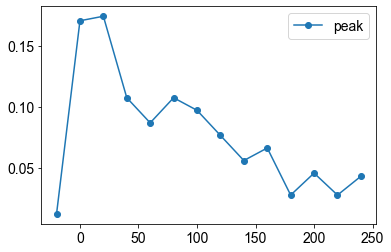

In [25]:
plt.figure()
#plt.plot(df_bhand_full_pn['firing_rate'], df_bhand_full_pn['fraction'], 'o-', label='full')
plt.plot(df_bhand_pn['firing_rate'], df_bhand_pn['fraction'], 'o-', label='peak')
plt.legend()
plt.show()


In [26]:
from utils.data_utils import make_df_AL_activity_long, make_orn_upn_frs, make_glomerular_odor_responses

In [27]:
from utils.plot_utils_EXTRA import plot_ornpn_hist, plot_fig_orn_pn_stats

In [28]:
doplots = 0

In [29]:
res_d = {}
full_d = {}
doplots = False
for i in range(njobs):

    runvals= dfpick[i]['simvals']
    df_AL_activity = dfpick[i]['df_AL_activity']

    df_AL_activity_long = make_df_AL_activity_long(df_AL_activity)
    # remove non olfactory glomeruli
    df_AL_activity_long = df_AL_activity_long[~df_AL_activity_long.glom.isin(thermo_hygro_glomeruli)]


    st = 'a{}_e{}_i{}_p{}'.format(*runvals)


    df_orn_frs, df_upn_frs = make_orn_upn_frs(df_AL_activity, odor_names, df_neur_ids,
                                              sub_pre=True, olf_only=True)

    if doplots:
        plot_ornpn_hist(df_AL_activity_long, df_orn_frs, df_upn_frs)#, savetag=st+'_hist_onoff', 
                    #saveplot=True, savetodir=plot_dir, showplot=0)

    df_orn_glom_onoff, df_upn_glom_onoff = make_glomerular_odor_responses(df_orn_frs, df_upn_frs, df_AL_activity)
    fig_orn_pn = plt.figure(figsize=(12, 12))
    orn_onoff_dists, upn_onoff_dists = plot_fig_orn_pn_stats(fig_orn_pn,
                                                             df_orn_glom_onoff, 
                                                             df_upn_glom_onoff, 
                                                             'bwr', savetag=st+'_hmap_onoff', 
                                                             saveplot=0, savetodir=plot_dir, showplot=0, 
                                                             doplot=False); plt.close()


    '''
    ### Z Scored
    df_orn_glom_onoff_Z = zscore(df_orn_glom_onoff); df_upn_glom_onoff_Z = zscore(df_upn_glom_onoff)
    fig_orn_pn_Z = plt.figure(figsize=(12, 12))
    plot_fig_orn_pn_stats(fig_orn_pn_Z, df_orn_glom_onoff_Z, df_upn_glom_onoff_Z, 'bwr', savetag=st+'_hmap_onoff_Z', 
                    saveplot=1, savetodir=plot_dir, showplot=0); plt.close()
    '''

    ### BHANDAWAT VERSION
    df_AL_activity_bhand  = df_AL_activity.copy()[((df_AL_activity.neur_type == 'ORN') & (df_AL_activity.glom.isin(bhand_gloms))) | 
              (df_AL_activity.neur_type.isin(['iLN', 'eLN'])) | 
               ((df_AL_activity.neur_type == 'uPN') & (df_AL_activity.glom.isin(bhand_gloms))) |
               (df_AL_activity.neur_type == 'mPN')
              ]
    df_AL_activity_long_bhand = make_df_AL_activity_long(df_AL_activity_bhand)
    df_orn_frs_bhand, df_upn_frs_bhand = make_orn_upn_frs(df_AL_activity_bhand, odor_names, df_neur_ids_bhand.reset_index(),
                                                  sub_pre=True, olf_only=True)
    #plot_ornpn_hist(df_AL_activity_long_bhand, 
    #                df_orn_frs_bhand, df_upn_frs_bhand, savetag=st+'_hist_onoff_bhand', 
    #                saveplot=1, savetodir=plot_dir, showplot=0); plt.close()

    df_orn_glom_onoff_bhand, df_upn_glom_onoff_bhand = \
        make_glomerular_odor_responses(df_orn_frs_bhand, df_upn_frs_bhand, df_AL_activity_bhand)
    fig_orn_pn_bhand = plt.figure(figsize=(12, 12))
    orn_bhand_dists, upn_bhand_dists = plot_fig_orn_pn_stats(fig_orn_pn_bhand,
                                                             df_orn_glom_onoff_bhand, 
                                                             df_upn_glom_onoff_bhand, 
                                                             'bwr', savetag=st+'_hmap_onoff_bhand', 
                                                             saveplot=0, savetodir=plot_dir, showplot=0,
                                                             doplot=False); plt.close()
    


    df_orn_OFF_frs, df_upn_OFF_frs = make_orn_upn_frs(df_AL_activity, odor_names, df_neur_ids,
                                              sub_pre=False, olf_only=True, use_pre=True)

    upn_off_mean = df_upn_OFF_frs.mean().mean()

    iln_off_mean, iln_on_mean, eln_off_mean, eln_on_mean = get_subtype_means(df_AL_activity)

    full_d[st] = {'df_upn_glom_onoff': df_upn_glom_onoff,
                  'df_upn_glom_onoff_bhand': df_upn_glom_onoff_bhand,
                  'upn_bhand_dists': upn_bhand_dists,
                  'upn_onoff_dists': upn_onoff_dists,
                  'df_upn_OFF_frs': df_upn_OFF_frs
                 }



    res_d[st] = {'mean_upn_onoff_dists': np.mean(upn_onoff_dists),
                 'std_upn_onoff_dists': np.std(upn_onoff_dists),
                 'mean_upn_bhand_dists': np.mean(upn_bhand_dists),
                 'std_upn_bhand_dists': np.std(upn_bhand_dists), 

                 'mean_upn_onoff': np.mean(df_upn_glom_onoff.values),
                 'std_upn_onoff': np.std(df_upn_glom_onoff.values),
                 'mean_upn_bhand': np.mean(df_upn_glom_onoff_bhand.values),
                 'std_upn_bhand': np.std(df_upn_glom_onoff_bhand.values),
                 'max_upn_bhand': np.max(df_upn_glom_onoff_bhand.values),
                 
                 'upn_off_mean': upn_off_mean,
                 'iln_off_mean': iln_off_mean, 'iln_on_mean': iln_on_mean,
                 'eln_off_mean': eln_off_mean, 'eln_on_mean': eln_on_mean,
                 
                 

                 'a': runvals[0], 'e': runvals[1], 'i': runvals[2], 'p': runvals[3]
                 #'frac_upn_dists_larger': sum(upn_onoff_dists > orn_onoff_dists) / len(upn_onoff_dists),
                 #'frac_upn_dists_larger_bhand': sum(upn_bhand_dists > orn_bhand_dists) / len(upn_bhand_dists)
                }

    if i % 20 == 0:
        print(i)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520


In [33]:
from sklearn.decomposition import PCA

def make_PCA_projections(df_orn_glom_onoff_bhand, df_upn_glom_onoff_bhand):
    
    # get odor x glomerulus tables for ORNs, uPNs
    df_sim_orn = df_orn_glom_onoff_bhand.T
    df_sim_upn = df_upn_glom_onoff_bhand.T
    # center them
    df_sim_orn_c = df_sim_orn - df_sim_orn.mean(0)
    df_sim_upn_c = df_sim_upn - df_sim_upn.mean(0)
    # perform PCA
    ornPCA = PCA()
    ornPCA.fit(df_sim_orn_c)
    orn_projections = ornPCA.fit_transform(df_sim_orn_c)[:, :2]
    upnPCA = PCA()
    upnPCA.fit(df_sim_upn_c)
    upn_projections = upnPCA.fit_transform(df_sim_upn_c)[:, :2]
    
    dfORNpca = orn_projections[:, :2]
    dfPNpca = upn_projections[:, :2]
    
    return dfORNpca, dfPNpca

def plot_PC_projections(dfORNpca, dfPNpca, odor_names, savetag='',
                    saveplot=False, savetodir='./', showplot=False):
    
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,4))
    axs[0].set_title('ORNs')
    for i in range(len(dfORNpca)):
        axs[0].scatter(dfORNpca[i, 1], dfORNpca[i, 0], label=odor_names[i])
    axs[0].set_xlabel('projection onto PC 2')
    axs[0].set_ylabel('projection onto PC 1')
    
    axs[1].set_title('PNs')
    for i in range(len(dfPNpca)):
        axs[1].scatter(dfPNpca[i, 1], dfPNpca[i, 0], label=odor_names[i])
    
    for ax in axs:
        #ax.axis('equal')
        ax.axvline(0, ls='--', color='0.5')
        ax.axhline(0, ls='--', color='0.5')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0, ncol=2)
    if saveplot:
        plt.savefig(os.path.join(savetodir, f'{savetag}.png'), bbox_inches='tight')
    if showplot:
        plt.show()
        
    plt.close()
    
    
def plot_PC_distances(bhand_pca_orndists, bhand_pca_pndists, savetag='',
                    saveplot=False, savetodir='./', showplot=False):
    
    mindist = min(min(bhand_pca_orndists), min(bhand_pca_pndists)); maxdist = max(max(bhand_pca_orndists), max(bhand_pca_pndists))
    b = np.linspace(mindist, maxdist, 2*12)  


    plt.figure(figsize=(13,4))
    ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((1, 3), (0, 2))
    
    ax1.hist(bhand_pca_orndists, alpha=0.5, bins=b, label='ORN', color='xkcd:light blue')
    ax1.hist(bhand_pca_pndists, alpha=0.5, bins=b, label='PN', color='xkcd:navy')
    ax1.set_xlabel('pairwise euclidean distance between\nPCA projected odors')
    ax1.set_ylabel('# odor pairs')
    ax1.legend()
    
    ax2.scatter(bhand_pca_orndists, bhand_pca_pndists, color='k')
    ax2.plot([mindist, maxdist], [mindist, maxdist], color='0.5', ls='--')
    ax2.axis('equal')
    ax2.set_xlabel('pairwise dist between ORN PCA-projected odors')
    ax2.set_ylabel('pairwise dist between PN PCA-projected odors')
    
    plt.subplots_adjust(wspace=0.4)
    
    if saveplot:
        plt.savefig(os.path.join(savetodir, f'{savetag}.png'), bbox_inches='tight')
    if showplot:
        plt.show()
        
    plt.close()

In [34]:
from scipy.stats import kstest, ks_2samp

In [35]:
bhand_df = pd.read_csv('../datasets/Bhandawat2007/fig3_responses/fig3_firing_rates.csv')
df_bhand_pn_glom_by_odor = bhand_df[bhand_df.cell_type == 'PN'].pivot('glomerulus', 'odor', 'firing_rate')
model_arr = df_bhand_pn_glom_by_odor.values.flatten()
dur_cols = [c for c in df_AL_activity.columns if '_dur_' in c]

In [36]:
res_d_PCA = {}
full_d_PCA = {}
doplots = False
for i in range(njobs):

    runvals= dfpick[i]['simvals']
    
    st = 'a{}_e{}_i{}_p{}'.format(*runvals)
    
    
    df_AL_activity = dfpick[i]['df_AL_activity']

    ### BHANDAWAT VERSION
    df_AL_activity_bhand  = df_AL_activity.copy()[((df_AL_activity.neur_type == 'ORN') & (df_AL_activity.glom.isin(bhand_gloms))) | 
              (df_AL_activity.neur_type.isin(['iLN', 'eLN'])) | 
               ((df_AL_activity.neur_type == 'uPN') & (df_AL_activity.glom.isin(bhand_gloms))) |
               (df_AL_activity.neur_type == 'mPN')
              ]
    df_orn_frs_onoff_bhand, df_upn_frs_onoff_bhand = make_orn_upn_frs(df_AL_activity_bhand, odor_names, df_neur_ids_bhand.reset_index(),
                                                  sub_pre=True, olf_only=True)
    
    df_orn_glom_by_odor_onoff_bhand, df_upn_glom_by_odor_onoff_bhand = \
        make_glomerular_odor_responses(df_orn_frs_onoff_bhand, df_upn_frs_onoff_bhand, df_AL_activity_bhand)
    
    dfORNpca, dfPNpca = make_PCA_projections(df_orn_glom_by_odor_onoff_bhand, df_upn_glom_by_odor_onoff_bhand)

    bhand_pca_orndists = pdist(dfORNpca, metric='euclidean')
    bhand_pca_pndists = pdist(dfPNpca, metric='euclidean')
    
    dm1_PN_pre_odor = df_AL_activity_bhand[df_AL_activity_bhand.neur_name == 'uPN_DM1_0']['fr_pre_odor0'].values[0]
    va2_PN_pre_odor = df_AL_activity_bhand[df_AL_activity_bhand.neur_name == 'uPN_VA2_0']['fr_pre_odor0'].values[0]
    vm2_PN_dur_all_odors = np.mean(df_AL_activity.loc[df_AL_activity.neur_name == 'uPN_VM2_0', dur_cols].values)
    
    bhand_arr = df_upn_glom_by_odor_onoff_bhand.values.flatten()
    kstest_stat, kstest_pval = kstest(model_arr, bhand_arr)
    kstest_2samp_stat, _ = ks_2samp(model_arr, bhand_arr)

    #plot_PC_projections(dfORNpca, dfPNpca, odor_names, 
    #                     savetag=st+'_PCA_projections', saveplot=1, savetodir=plot_dir, showplot=0)
    #plot_PC_distances(bhand_pca_orndists, bhand_pca_pndists,
    #                     savetag=st+'_PCA_distances', saveplot=1, savetodir=plot_dir, showplot=0)
    res_d_PCA[st] = {'mean_pca_orn_dists': np.mean(bhand_pca_orndists), 
                     'std_pca_orn_dists': np.std(bhand_pca_orndists),
                     'mean_pca_upn_dists': np.mean(bhand_pca_pndists),
                     'std_pca_upn_dists': np.std(bhand_pca_pndists),
                     'max_pca_upn_dists': np.max(bhand_pca_pndists),
                     'DM1_PN_pre_odor_fr': dm1_PN_pre_odor,
                     'VA2_PN_pre_odor_fr': va2_PN_pre_odor,
                     'VM2_PN_dur_odor_fr': vm2_PN_dur_all_odors,
                     'min_PN_dur': np.min(bhand_arr),
                     'kstest_stat': kstest_stat, 'kstest_pval': kstest_pval,
                     'kstest_2samp_stat': kstest_2samp_stat,
                     'a': runvals[0], 'e': runvals[1], 'i': runvals[2], 'p': runvals[3]
                }
    ## near 500
    ## if st == 'a0.1_e0.25_i0.2_p6.0':
    ##   break
    ## near 320
    ##if st == 'a0.1_e0.4_i0.2_p4.0':
    ##   break
        
    if i % 20 == 0:
        print(i)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520


In [37]:
new_d = {}
for i in range(njobs):

    runvals= dfpick[i]['simvals']   
    st = 'a{}_e{}_i{}_p{}'.format(*runvals)
    
    cur_d = full_d[st]
    
    frs_upn_glom_onoff = cur_d['df_upn_glom_onoff'].values.flatten()
    frs_upn_glom_onoff_bhand = cur_d['df_upn_glom_onoff_bhand'].values.flatten()
    
    frac_less_full = sum(frs_upn_glom_onoff < 100) / len(frs_upn_glom_onoff)
    frac_less_bhand = sum(frs_upn_glom_onoff_bhand < 100) / len(frs_upn_glom_onoff_bhand)
    
    # squared distance from Bhandawat hist
    # align to bhandawat data
    b = np.arange(-200, 500, 20)
    cnts, left_pts = np.histogram(cur_d['df_upn_glom_onoff_bhand'].values.flatten(), bins=b)
    sim_pn_fracs = pd.Series(cnts/sum(cnts), index=left_pts[:-1], name='sim_PN')
    sim_pn_fracs.index = sim_pn_fracs.index.rename('fr')
    df_compare_pns_peak = pd.DataFrame(sim_pn_fracs).merge(df_bhand_pn, left_on='fr', 
                                                       right_on='firing_rate').fillna(0)
    pn_sq_dist_bhandgloms = np.sum((df_compare_pns_peak['fraction'] - df_compare_pns_peak['sim_PN'])**2)
    
    cnts, left_pts = np.histogram(cur_d['df_upn_glom_onoff'].values.flatten(), bins=b)
    sim_pn_fracs = pd.Series(cnts/sum(cnts), index=left_pts[:-1], name='sim_PN')
    sim_pn_fracs.index = sim_pn_fracs.index.rename('fr')
    df_compare_pns_peak = pd.DataFrame(sim_pn_fracs).merge(df_bhand_pn, left_on='fr', 
                                                       right_on='firing_rate').fillna(0)
    pn_sq_dist_allgloms = np.sum((df_compare_pns_peak['fraction'] - df_compare_pns_peak['sim_PN'])**2)
    
    
    
    new_d[st] = {'frac_less_full': frac_less_full,
                 'frac_less_bhand': frac_less_bhand,
                 'pn_sq_dist_bhandgloms': pn_sq_dist_bhandgloms,
                 'pn_sq_dist_allgloms': pn_sq_dist_allgloms,
                 }

In [38]:
df_res = pd.DataFrame.from_dict(res_d).T
df_new = pd.DataFrame.from_dict(new_d).T
df_res = pd.concat((df_res, df_new), 1)

df_res_PCA = pd.DataFrame.from_dict(res_d_PCA).T

df_res = pd.concat((df_res, df_res_PCA), 1)
df_res = df_res.loc[:,~df_res.columns.duplicated()]

In [39]:
df_res_cols = df_res.columns
df_res_cols
df_res_cols1 = [c for c in df_res_cols if c not in ['a', 'e', 'i', 'p']]

In [40]:
def plot_sweep_res(x_var, y_var, c_var, x_lab='', y_lab='', c_lab='', 
                   highlight_locs=['a0.1_e0.25_i0.65_p8.0']):
    
    x_lab = x_var if x_lab == '' else x_lab
    y_lab = y_var if y_lab == '' else y_lab
    c_lab = c_var if c_lab == '' else c_lab
    
    plot_df = df_res
    plt.figure(figsize=(12,7))
    # all sims
    sc = plt.scatter(plot_df[x_var], plot_df[y_var], c=plot_df[c_var])
    # highlight base paramter config
    
    for loc in highlight_locs:
        plot_df = df_res.loc[loc]
        plt.scatter(plot_df[x_var], plot_df[y_var], label=loc, edgecolor='w', linewidth=2, marker='*', s=500)
    
    #plot_df = df_res.loc['a0.1_e0.25_i0.45_p6.0']
    #plt.scatter(plot_df[x_var], plot_df[y_var], c='r', marker='*', s=300)
    if len(highlight_locs) > 0:
        plt.legend(title='highlighted runs', bbox_to_anchor=(1.15, 1), loc='upper left', borderaxespad=0)
    plt.xlabel(x_lab); plt.ylabel(y_lab)
    plt.colorbar(sc, label=c_lab)
    plt.show()
    
    return x_var, y_var, c_var

In [41]:
df_simvals = df_res[['a', 'e', 'i', 'p']].sort_values(['a', 'e', 'i', 'p']).reset_index(drop=True)
df_simvals['success'] = 1

a_vals = df_simvals['a'].value_counts().index.values
e_vals = df_simvals['e'].value_counts().index.values
i_vals = df_simvals['i'].value_counts().index.values
p_vals = df_simvals['p'].value_counts().index.values

rows_to_add = []
for a_val in a_vals:
    sub_1df = df_simvals[df_simvals['a'] == a_val]

    for e_val in e_vals:
        sub_2df = sub_1df[sub_1df['e'] == e_val]
        for i_val in i_vals:
            sub_3df = sub_2df[sub_2df['i'] == i_val]
            for p_val in p_vals:
                sub_4df = sub_3df[sub_3df['p'] == p_val]
                if sub_4df.shape[0] == 0:
                    new_row = [a_val, e_val, i_val, p_val, 0]
                    rows_to_add.append(new_row)
                    
df_simvals_unsuccessful = pd.DataFrame(rows_to_add, columns=['a', 'e', 'i', 'p', 'success'])
df_simvals = pd.concat((df_simvals, df_simvals_unsuccessful)).sort_values(['a', 'e', 'i', 'p']).reset_index(drop=True)
df_simvals

,a,e,i,p,success
0,0.1,0.1,0.2,2.0,1
1,0.1,0.1,0.2,4.0,1
2,0.1,0.1,0.2,6.0,1
3,0.1,0.1,0.2,8.0,1
4,0.1,0.1,0.2,10.0,1
...,...,...,...,...,...
580,0.1,0.5,1.0,2.0,1
581,0.1,0.5,1.0,4.0,1
582,0.1,0.5,1.0,6.0,1
583,0.1,0.5,1.0,8.0,1


In [42]:
## finding 

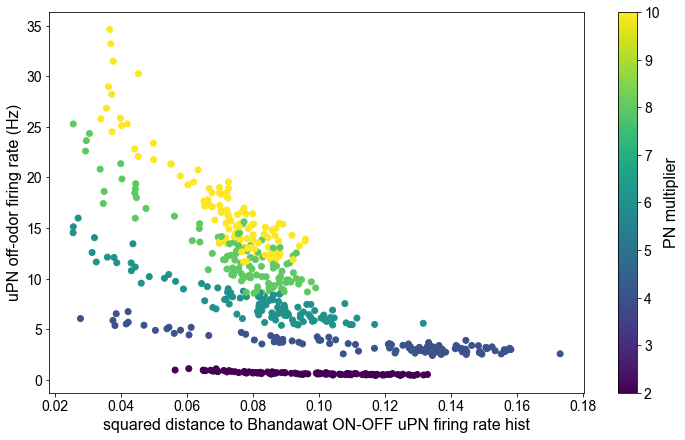

In [43]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'pn_sq_dist_bhandgloms', x_lab = 'squared distance to Bhandawat ON-OFF uPN firing rate hist',
    y_var = 'upn_off_mean', y_lab = 'uPN off-odor firing rate (Hz)',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=[],#'a0.1_e0.4_i0.2_p4.0']
)



In [68]:
sub_df = df_res[
       #(df_res['p'] == 4) & 
       (df_res[x_var] < 0.03) &
       (df_res[y_var] < 15) &
       #(df_res['upn_off_mean'] < 20) &
       #(df_res['eln_on_mean'] < 40) &
       #(df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('upn_off_mean')[df_res_cols1].sort_values('max_pca_upn_dists')[['pn_sq_dist_bhandgloms', 'upn_off_mean']]

,pn_sq_dist_bhandgloms,upn_off_mean
a0.1_e0.4_i0.2_p4.0,0.027608,6.052991
a0.1_e0.4_i0.2_p6.0,0.025386,14.531624


In [69]:
df_res_cols1

['mean_upn_onoff_dists',
 'std_upn_onoff_dists',
 'mean_upn_bhand_dists',
 'std_upn_bhand_dists',
 'mean_upn_onoff',
 'std_upn_onoff',
 'mean_upn_bhand',
 'std_upn_bhand',
 'max_upn_bhand',
 'upn_off_mean',
 'iln_off_mean',
 'iln_on_mean',
 'eln_off_mean',
 'eln_on_mean',
 'frac_less_full',
 'frac_less_bhand',
 'pn_sq_dist_bhandgloms',
 'pn_sq_dist_allgloms',
 'mean_pca_orn_dists',
 'std_pca_orn_dists',
 'mean_pca_upn_dists',
 'std_pca_upn_dists',
 'max_pca_upn_dists',
 'DM1_PN_pre_odor_fr',
 'VA2_PN_pre_odor_fr',
 'VM2_PN_dur_odor_fr',
 'min_PN_dur',
 'kstest_stat',
 'kstest_pval',
 'kstest_2samp_stat']

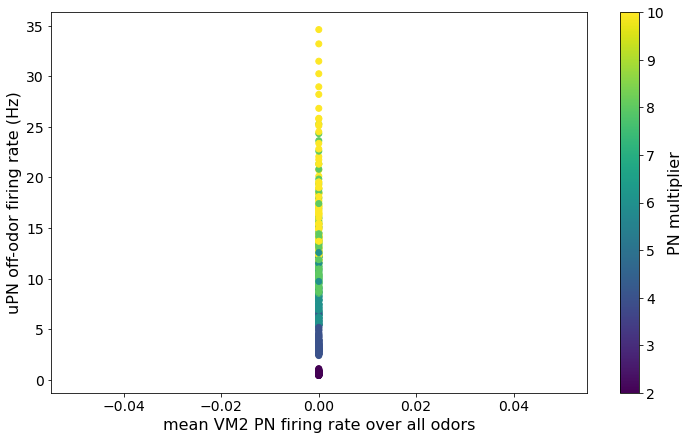

In [70]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'VM2_PN_dur_odor_fr', x_lab = 'mean VM2 PN firing rate over all odors',
    y_var = 'upn_off_mean', y_lab = 'uPN off-odor firing rate (Hz)',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=[],#'a0.1_e0.4_i0.2_p4.0']
)



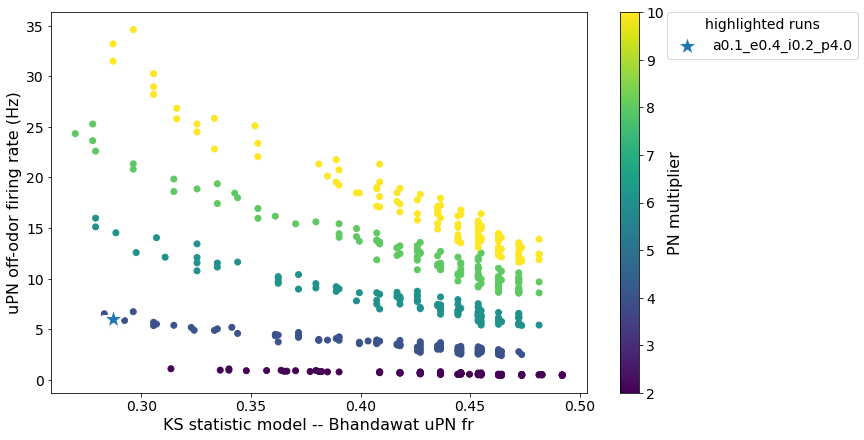

In [76]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'kstest_stat', x_lab = 'KS statistic model -- Bhandawat uPN fr',
    y_var = 'upn_off_mean', y_lab = 'uPN off-odor firing rate (Hz)',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=['a0.1_e0.4_i0.2_p4.0']
)



In [78]:
sub_df = df_res[
       #(df_res['p'] == 4) & 
       (df_res[x_var] < 0.32) &
       (df_res[y_var] < 10) &
       #(df_res['upn_off_mean'] < 20) &
       #(df_res['eln_on_mean'] < 40) &
       #(df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('upn_off_mean')[df_res_cols1].sort_values('max_pca_upn_dists')[['pn_sq_dist_bhandgloms', 'upn_off_mean']]

,pn_sq_dist_bhandgloms,upn_off_mean
a0.1_e0.5_i0.2_p2.0,0.060490,1.102564
a0.1_e0.3_i0.2_p4.0,0.042108,5.692308
a0.1_e0.25_i0.2_p4.0,0.041499,5.517949
a0.1_e0.5_i0.2_p4.0,0.042068,6.736752
a0.1_e0.15_i0.2_p4.0,0.046887,5.394872
a0.1_e0.4_i0.2_p4.0,0.027608,6.052991
a0.1_e0.2_i0.2_p4.0,0.038086,5.365812
a0.1_e0.35_i0.2_p4.0,0.037471,5.866667
a0.1_e0.45_i0.2_p4.0,0.038452,6.529915


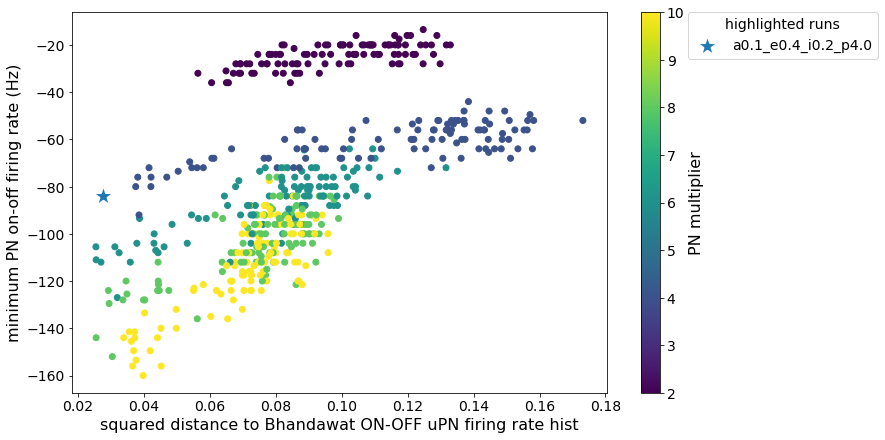

In [86]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'pn_sq_dist_bhandgloms', x_lab = 'squared distance to Bhandawat ON-OFF uPN firing rate hist',
    y_var = 'min_PN_dur', y_lab = 'minimum PN on-off firing rate (Hz)',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=['a0.1_e0.4_i0.2_p4.0']
)



Identifying the model with ORNs x0.1, eLNs x0.04, iLNs x0.02, PNs x 0.4 as the best-performing model, with small deviation to the Bhandawat 2007 et al ON-OFF PN firing rate distribution, and not-too-negative minimum PN on-off firing rate.

In [87]:
sub_df = df_res[
       #(df_res['p'] == 6) & 
       (df_res[x_var] < 0.041) &
       (df_res[y_var] > -100) &
       #(df_res['upn_off_mean'] < 15) &
       #(df_res['eln_on_mean'] < 40) &
       # (df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('pn_sq_dist_bhandgloms')[['pn_sq_dist_bhandgloms', 'a']]

,pn_sq_dist_bhandgloms,a
a0.1_e0.4_i0.2_p4.0,0.027608,0.1
a0.1_e0.35_i0.2_p4.0,0.037471,0.1
a0.1_e0.2_i0.2_p4.0,0.038086,0.1
a0.1_e0.45_i0.2_p4.0,0.038452,0.1
a0.1_e0.45_i0.3_p6.0,0.038618,0.1


In [54]:
df_res.columns

Index(['mean_upn_onoff_dists', 'std_upn_onoff_dists', 'mean_upn_bhand_dists',
       'std_upn_bhand_dists', 'mean_upn_onoff', 'std_upn_onoff',
       'mean_upn_bhand', 'std_upn_bhand', 'max_upn_bhand', 'upn_off_mean',
       'iln_off_mean', 'iln_on_mean', 'eln_off_mean', 'eln_on_mean', 'a', 'e',
       'i', 'p', 'frac_less_full', 'frac_less_bhand', 'pn_sq_dist_bhandgloms',
       'pn_sq_dist_allgloms', 'mean_pca_orn_dists', 'std_pca_orn_dists',
       'mean_pca_upn_dists', 'std_pca_upn_dists', 'max_pca_upn_dists',
       'DM1_PN_pre_odor_fr', 'VA2_PN_pre_odor_fr', 'kstest_stat',
       'kstest_pval', 'kstest_2samp_stat'],
      dtype='object')

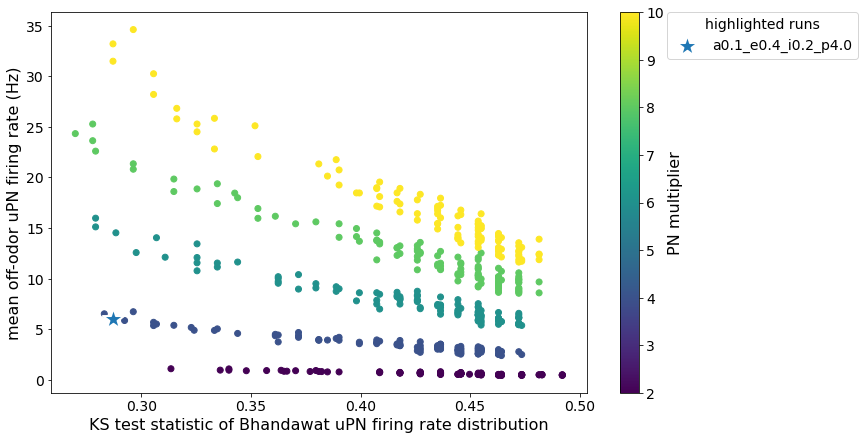

In [104]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'kstest_stat', x_lab = 'KS test statistic of Bhandawat uPN firing rate distribution',
    y_var = 'upn_off_mean', y_lab = 'mean off-odor uPN firing rate (Hz)',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=['a0.1_e0.4_i0.2_p4.0'],#'a0.1_e0.25_i0.2_p6.0']
    #highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
    #                'a0.1_e0.25_i0.45_p6.0',
    #                'a0.1_e0.3_i0.45_p4.0']
)



In [105]:
sub_df = df_res[
       #(df_res['p'] == 6) & 
       (df_res[x_var] < 0.33) &
       (df_res[y_var] < 7) &
       #(df_res['upn_off_mean'] < 15) &
       #(df_res['eln_on_mean'] < 40) &
       # (df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('kstest_stat')

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,std_pca_orn_dists,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,VM2_PN_dur_odor_fr,kstest_stat,kstest_pval,kstest_2samp_stat
a0.1_e0.45_i0.2_p4.0,561.069537,118.254581,280.417160,93.802481,45.591644,66.109681,63.685957,89.131529,286.50,6.529915,...,77.647375,220.157914,107.310734,508.552228,68.0,28.0,0.0,0.283069,0.000133,0.283069
a0.1_e0.4_i0.2_p4.0,566.496508,118.855839,285.256129,95.201347,45.694408,66.429010,64.111883,90.134273,293.00,6.052991,...,77.062060,221.199050,110.536663,494.742969,76.0,32.0,0.0,0.287037,0.000101,0.287037
a0.1_e0.35_i0.2_p4.0,568.394040,117.936114,285.012905,97.093254,45.112219,66.444472,63.020062,90.200823,305.00,5.866667,...,77.591758,220.694763,109.751562,501.564582,76.0,40.0,0.0,0.292328,0.000070,0.292328
a0.1_e0.5_i0.2_p4.0,565.046197,118.863910,280.537383,93.504112,46.216880,66.479202,63.301698,88.809643,283.25,6.736752,...,78.088934,220.248523,106.808077,491.910384,76.0,28.0,0.0,0.296296,0.000053,0.296296
a0.1_e0.3_i0.2_p4.0,566.225195,117.633535,286.758283,97.868763,44.782580,66.324000,63.459105,90.891225,289.00,5.692308,...,77.843352,224.940710,111.359087,483.852508,80.0,24.0,0.0,0.305556,0.000027,0.305556
a0.1_e0.2_i0.2_p4.0,568.066928,119.482380,286.426757,97.480844,43.629021,66.228442,61.815586,90.639696,299.00,5.365812,...,77.740798,223.546464,111.501029,495.291830,64.0,36.0,0.0,0.305556,0.000027,0.305556
a0.1_e0.25_i0.2_p4.0,564.584218,118.725497,285.200934,96.499578,44.240418,66.089001,63.312500,90.158445,293.00,5.517949,...,78.788990,221.808726,111.246110,483.867013,68.0,36.0,0.0,0.306878,0.000024,0.306878
a0.1_e0.5_i0.2_p2.0,393.964029,85.008461,212.950745,82.155096,26.962450,46.109054,51.702160,68.006745,266.50,1.102564,...,76.949838,167.150844,93.254952,382.415942,32.0,0.0,0.0,0.313492,0.000015,0.313492
a0.1_e0.15_i0.2_p4.0,568.005206,118.069873,286.879907,97.889750,42.596982,65.893291,62.131173,90.703323,301.00,5.394872,...,77.930849,223.979962,111.217059,494.620908,64.0,28.0,0.0,0.314815,0.000013,0.314815
a0.1_e0.5_i0.3_p4.0,568.655252,118.771030,287.669949,98.321139,43.231309,66.185090,62.490741,90.913906,292.50,5.181197,...,77.384793,226.227176,112.067239,479.039795,60.0,28.0,0.0,0.322751,0.000007,0.322751


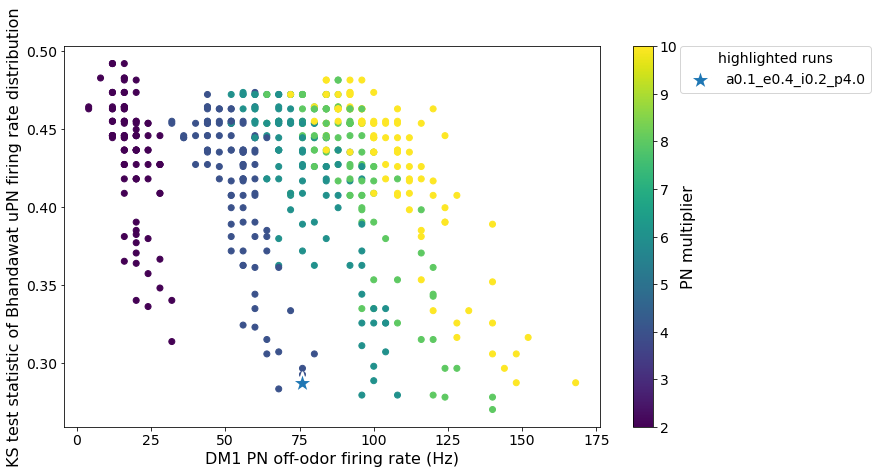

In [107]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'DM1_PN_pre_odor_fr', x_lab = 'DM1 PN off-odor firing rate (Hz)',
    y_var = 'kstest_stat', y_lab = 'KS test statistic of Bhandawat uPN firing rate distribution',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=['a0.1_e0.4_i0.2_p4.0'],#, 'a0.1_e0.5_i0.2_p2.0']
    #highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
    #                'a0.1_e0.25_i0.45_p6.0',
    #                'a0.1_e0.3_i0.45_p4.0']
)



In [154]:
sub_df = df_res[
       #(df_res['p'] == 6) & 
       (df_res[x_var] < 40) &
       (df_res[y_var] < 0.33) &
       #(df_res['upn_off_mean'] < 15) &
       #(df_res['eln_on_mean'] < 40) &
       # (df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('kstest_stat')

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,mean_pca_orn_dists,std_pca_orn_dists,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,kstest_stat,kstest_pval,kstest_2samp_stat
a0.1_e0.5_i0.2_p2.0,393.964029,85.008461,212.950745,82.155096,26.96245,46.109054,51.70216,68.006745,266.5,1.102564,...,116.419447,76.949838,167.150844,93.254952,382.415942,32.0,0.0,0.313492,0.000015,0.313492


In [157]:
sub_df = df_res[
       #(df_res['p'] == 6) & 
       (df_res[x_var] < 75) &
       (df_res[y_var] < 0.3) &
       #(df_res['upn_off_mean'] < 15) &
       #(df_res['eln_on_mean'] < 40) &
       # (df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('kstest_stat')

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,mean_pca_orn_dists,std_pca_orn_dists,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,kstest_stat,kstest_pval,kstest_2samp_stat
a0.1_e0.45_i0.2_p4.0,561.069537,118.254581,280.41716,93.802481,45.591644,66.109681,63.685957,89.131529,286.5,6.529915,...,116.19478,77.647375,220.157914,107.310734,508.552228,68.0,28.0,0.283069,0.000133,0.283069


In [56]:
df_res

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,mean_pca_orn_dists,std_pca_orn_dists,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,kstest_stat,kstest_pval,kstest_2samp_stat
a0.1_e0.3_i0.55_p2.0,381.585481,80.735870,210.078650,85.150640,22.117180,43.534798,45.641975,67.261350,268.0,0.634188,...,116.576351,77.253603,164.779997,94.895721,389.959052,20.0,0.0,0.445767,6.311673e-11,0.445767
a0.1_e0.15_i0.5_p6.0,679.087834,135.657443,337.166323,110.576977,47.321228,78.091623,64.293981,105.142921,324.5,7.317949,...,117.127495,78.365664,258.897442,129.044101,553.185918,92.0,44.0,0.435185,2.028138e-10,0.435185
a0.1_e0.2_i0.6_p10.0,827.691339,160.032956,388.968267,121.068644,57.896700,94.422903,69.335648,119.935443,330.5,15.237607,...,116.660142,76.860698,298.785490,142.159443,668.001045,104.0,44.0,0.455026,2.213274e-11,0.455026
a0.1_e0.3_i0.2_p4.0,566.225195,117.633535,286.758283,97.868763,44.782580,66.324000,63.459105,90.891225,289.0,5.692308,...,117.425213,77.843352,224.940710,111.359087,483.852508,80.0,24.0,0.305556,2.694667e-05,0.305556
a0.1_e0.1_i1.0_p6.0,665.536177,127.433081,335.691346,115.780241,42.656177,76.002476,60.388117,105.017217,330.0,5.381197,...,117.157503,78.224406,261.471543,134.396519,579.047905,56.0,36.0,0.473545,2.523870e-12,0.473545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a0.1_e0.35_i0.75_p2.0,379.044855,81.369502,212.633299,87.639205,21.322640,43.178746,45.108025,68.054336,288.0,0.557265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a0.1_e0.1_i0.45_p4.0,560.186470,113.096045,288.293516,101.059477,37.638903,64.406529,58.203704,90.929959,301.5,3.682051,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a0.1_e0.25_i1.0_p6.0,665.543281,131.216661,334.868372,117.026182,43.339284,76.097793,60.834105,104.852360,322.0,5.413675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a0.1_e0.3_i1.0_p8.0,754.120810,145.074552,365.763117,118.683907,49.876058,86.138714,66.948302,113.496481,351.5,8.707692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
sub_df = df_res[
       #(df_res['p'] == 6) & 
       (df_res[x_var] < 15) &
       (df_res[y_var] < 0.3) &
       #(df_res['upn_off_mean'] < 15) &
       #(df_res['eln_on_mean'] < 40) &
       # (df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('kstest_stat')

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,pn_sq_dist_allgloms,mean_pca_orn_dists,std_pca_orn_dists,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,kstest_stat,kstest_pval
a0.1_e0.45_i0.2_p4.0,561.069537,118.254581,280.417160,93.802481,45.591644,66.109681,63.685957,89.131529,286.50,6.529915,...,0.075500,116.194780,77.647375,220.157914,107.310734,508.552228,68.0,28.0,0.283069,0.000133
a0.1_e0.4_i0.2_p4.0,566.496508,118.855839,285.256129,95.201347,45.694408,66.429010,64.111883,90.134273,293.00,6.052991,...,0.077460,117.330098,77.062060,221.199050,110.536663,494.742969,76.0,32.0,0.287037,0.000101
a0.1_e0.4_i0.2_p6.0,669.982874,140.147893,318.770274,101.372736,56.368233,78.437210,69.265432,100.485247,307.00,14.531624,...,0.053003,117.631435,78.154404,246.929901,116.653207,552.131329,100.0,56.0,0.288360,0.000092
a0.1_e0.35_i0.2_p4.0,568.394040,117.936114,285.012905,97.093254,45.112219,66.444472,63.020062,90.200823,305.00,5.866667,...,0.079392,117.584968,77.591758,220.694763,109.751562,501.564582,76.0,40.0,0.292328,0.000070
a0.1_e0.5_i0.2_p4.0,565.046197,118.863910,280.537383,93.504112,46.216880,66.479202,63.301698,88.809643,283.25,6.736752,...,0.068523,116.913022,78.088934,220.248523,106.808077,491.910384,76.0,28.0,0.296296,0.000053
a0.1_e0.25_i0.2_p6.0,674.283240,139.512790,323.126682,103.155703,55.472431,78.685851,66.793210,101.396118,308.50,12.579487,...,0.059437,117.169383,77.911817,248.090717,118.693960,569.001946,100.0,60.0,0.297619,0.000048


In [45]:
sub_df = df_res[
       #(df_res['p'] == 6) & 
       (df_res[x_var] > 0.48) &
       #(df_res[y_var] < 0.03) &
       #(df_res['upn_off_mean'] < 15) &
       #(df_res['eln_on_mean'] < 40) &
       # (df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('kstest_stat')

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,pn_sq_dist_allgloms,mean_pca_orn_dists,std_pca_orn_dists,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,kstest_stat,kstest_pval
a0.1_e0.15_i0.8_p2.0,377.252978,80.137844,211.993837,89.220071,20.840350,42.810237,43.971451,67.856776,284.0,0.499145,...,0.308174,118.354983,78.617761,167.674772,99.574648,392.778399,20.0,0.0,0.481481,9.650059e-13
a0.1_e0.4_i0.8_p2.0,378.825858,80.549003,211.475419,86.623523,21.180832,43.114769,44.709877,67.569474,282.5,0.509402,...,0.308684,117.665021,77.823239,167.005645,96.200900,388.811711,16.0,4.0,0.481481,9.650059e-13
a0.1_e0.25_i0.8_p8.0,753.889485,148.805658,369.446186,120.364366,51.316045,86.375443,67.922068,114.729869,334.0,9.676923,...,0.107551,117.891276,78.511299,286.181455,140.577017,599.173153,88.0,32.0,0.481481,9.650059e-13
a0.1_e0.1_i1.0_p10.0,816.648523,155.726748,395.177809,128.303210,53.292633,92.774547,68.191358,121.694211,354.5,11.876923,...,0.105764,118.079413,78.445492,305.831670,151.250158,653.006638,84.0,36.0,0.481481,9.650059e-13
a0.1_e0.15_i0.7_p10.0,828.050321,160.363832,397.431315,123.666295,56.391839,94.353534,70.621914,122.315630,350.5,13.902564,...,0.091690,117.568546,78.058825,303.472111,147.300937,646.344955,84.0,48.0,0.481481,9.650059e-13
a0.1_e0.15_i1.0_p8.0,749.625441,144.549669,366.295539,124.427644,49.089393,85.602413,65.984568,114.368743,336.5,8.596581,...,0.116876,117.858307,78.092805,287.296803,145.095270,632.967009,88.0,40.0,0.481481,9.650059e-13
a0.1_e0.2_i0.9_p10.0,819.420990,155.212251,393.617041,124.446848,54.688621,93.285961,68.895833,121.643134,344.0,12.434188,...,0.105833,116.714406,78.004892,301.599100,146.767501,623.334932,96.0,40.0,0.481481,9.650059e-13
a0.1_e0.15_i0.9_p10.0,819.762107,154.609401,395.272815,126.024436,54.429471,93.346176,69.321759,121.853049,354.5,12.384615,...,0.101660,117.187739,78.040884,300.071485,151.878772,644.320889,92.0,48.0,0.481481,9.650059e-13
a0.1_e0.25_i1.0_p6.0,665.543281,131.216661,334.868372,117.026182,43.339284,76.097793,60.834105,104.852360,322.0,5.413675,...,0.124504,118.035529,77.910762,262.600913,133.579838,581.738120,68.0,32.0,0.481481,9.650059e-13
a0.1_e0.3_i0.9_p2.0,375.943213,79.073431,208.080398,86.639007,20.694254,42.627231,43.433642,66.506481,273.5,0.529915,...,0.322176,116.341731,77.394930,164.245089,95.543823,382.736562,16.0,0.0,0.482804,8.197887e-13


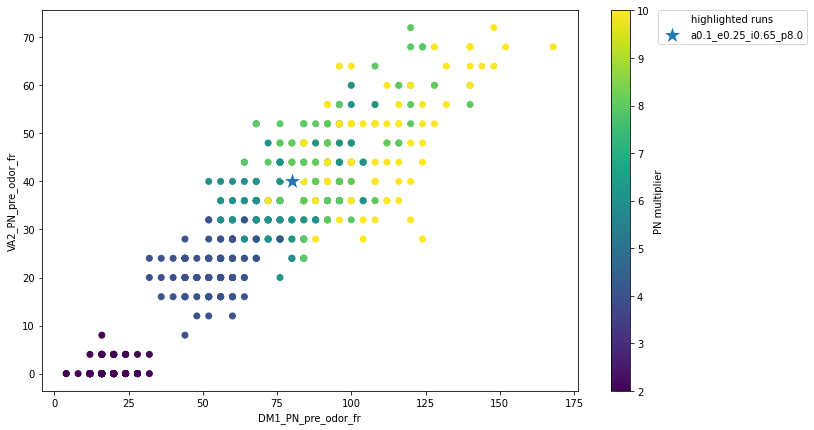

In [41]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'DM1_PN_pre_odor_fr',
    y_var = 'VA2_PN_pre_odor_fr',
    c_var = 'p', c_lab='PN multiplier',
    #highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
    #                'a0.1_e0.25_i0.45_p6.0',
    #                'a0.1_e0.3_i0.45_p4.0']
)



In [45]:
l = [4, 5, 2, 5, 3]

In [48]:
pd.Series(l).drop_duplicates()

0    4
1    5
2    2
4    3
dtype: int64

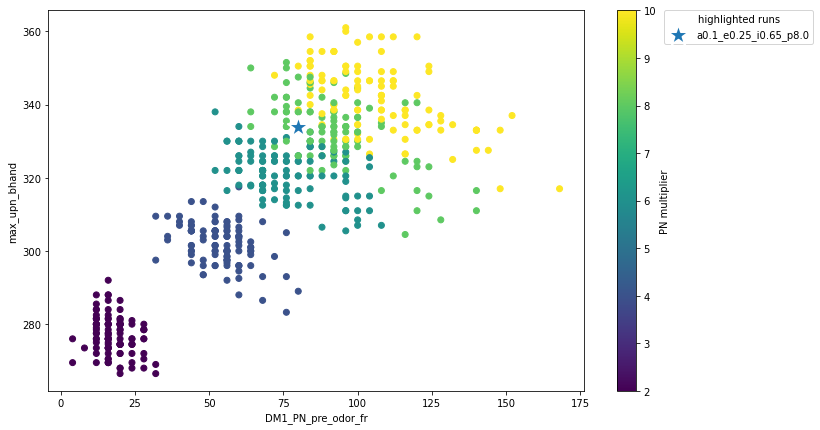

In [111]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'DM1_PN_pre_odor_fr',
    y_var = 'max_upn_bhand',
    c_var = 'p', c_lab='PN multiplier',
    #highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
    #                'a0.1_e0.25_i0.45_p6.0',
    #                'a0.1_e0.3_i0.45_p4.0']
)



In [116]:
sub_df = df_res[
       #(df_res['p'] == 6) & 
       (df_res[x_var] < 30) &
       #(df_res[y_var] < 0.03) &
       #(df_res['upn_off_mean'] < 15) &
       #(df_res['eln_on_mean'] < 40) &
       # (df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('frac_less_bhand')['frac_less_bhand']#.iloc[:5]

a0.1_e0.35_i0.2_p2.0    0.787037
a0.1_e0.2_i0.2_p2.0     0.796296
a0.1_e0.15_i0.2_p2.0    0.796296
a0.1_e0.3_i0.2_p2.0     0.796296
a0.1_e0.5_i0.3_p2.0     0.796296
                          ...   
a0.1_e0.45_i0.8_p2.0    0.824074
a0.1_e0.25_i0.9_p2.0    0.824074
a0.1_e0.15_i0.9_p2.0    0.824074
a0.1_e0.15_i0.6_p2.0    0.824074
a0.1_e0.4_i1.0_p2.0     0.824074
Name: frac_less_bhand, Length: 103, dtype: float64

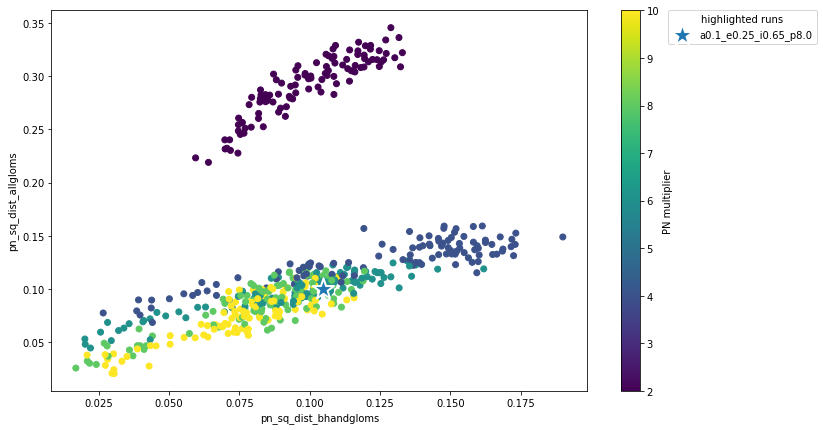

In [78]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'pn_sq_dist_bhandgloms',
    y_var = 'pn_sq_dist_allgloms',
    c_var = 'p', c_lab='PN multiplier',
    #highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
    #                'a0.1_e0.25_i0.45_p6.0',
    #                'a0.1_e0.3_i0.45_p4.0']
)



In [79]:
foo

NameError: name 'foo' is not defined

In [80]:
sub_df = df_res[
       #(df_res['p'] == 6) & 
       #(df_res[x_var] < 0.05) &
       #(df_res[y_var] < 0.03) &
       (df_res['upn_off_mean'] < 15) &
       (df_res['eln_on_mean'] < 40) &
        (df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('frac_less_full')#.iloc[:5]

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,p,frac_less_full,frac_less_bhand,pn_sq_dist_bhandgloms,pn_sq_dist_allgloms,mean_pca_orn_dists,std_pca_orn_dists,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists
a0.1_e0.45_i0.7_p10.0,827.818984,160.465263,390.148247,121.158004,59.082131,94.685433,72.739198,120.215683,360.0,14.789744,...,10.0,0.734205,0.629630,0.099171,0.080313,116.990453,77.667778,299.102871,142.858804,667.148459
a0.1_e0.5_i0.7_p10.0,824.919928,159.561153,387.096334,117.594138,59.455043,94.361615,73.059414,119.207710,346.5,14.905983,...,10.0,0.734205,0.638889,0.077616,0.077470,117.330177,77.705046,295.077607,139.712378,636.488931
a0.1_e0.4_i0.7_p10.0,824.270726,160.320813,390.802002,117.898953,58.828636,94.436511,71.989198,120.068436,350.5,14.331624,...,10.0,0.736383,0.648148,0.089086,0.079535,117.542265,77.867161,299.139001,139.954253,634.926155
a0.1_e0.5_i0.45_p8.0,761.203271,150.875525,359.571902,111.305996,58.581944,87.947689,72.225309,111.499993,320.5,14.437607,...,8.0,0.736383,0.657407,0.083725,0.068762,117.174790,77.784296,276.473570,130.699071,579.975965
a0.1_e0.25_i0.7_p10.0,821.701911,159.646790,389.966036,121.453887,57.415714,93.850111,71.070216,120.233301,358.5,13.989744,...,10.0,0.737473,0.638889,0.081540,0.090886,117.194821,78.077421,299.690901,144.143869,642.622322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a0.1_e0.25_i0.9_p2.0,375.817339,80.217795,211.199818,88.736338,20.595579,42.569444,43.259259,67.505767,277.5,0.512821,...,2.0,0.930283,0.824074,0.108009,0.316684,117.334705,77.161342,166.395736,99.333250,385.785486
a0.1_e0.15_i1.0_p2.0,373.426258,78.645838,209.662789,89.580343,20.163140,42.332461,43.496142,67.420951,284.0,0.483761,...,2.0,0.931373,0.824074,0.119797,0.328637,117.984232,78.431860,165.102834,99.140760,392.218200
a0.1_e0.35_i1.0_p2.0,373.518852,78.936291,208.476386,86.740892,20.579362,42.549451,44.505401,67.102198,277.5,0.459829,...,2.0,0.931373,0.814815,0.124697,0.324027,116.780898,77.686031,164.622089,96.252627,392.017388
a0.1_e0.15_i0.9_p2.0,374.569938,79.686900,210.097294,87.306762,20.476012,42.468602,43.299383,67.176863,281.5,0.478632,...,2.0,0.931373,0.824074,0.131717,0.336375,116.879517,77.983347,165.246138,96.794550,387.032655


In [81]:
highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
                 'a0.1_e0.4_i0.75_p6.0']

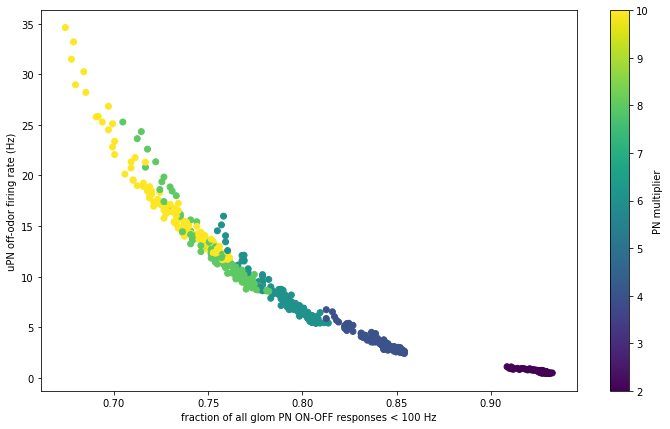

In [82]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'frac_less_full', x_lab = 'fraction of all glom PN ON-OFF responses < 100 Hz',
    y_var = 'upn_off_mean', y_lab = 'uPN off-odor firing rate (Hz)',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=[]
)



In [83]:
sub_df = df_res[
       #(df_res['p'] == 4) & 
       (df_res[x_var] < 0.8) &
       (df_res[y_var] < 15) &
       #(df_res['upn_off_mean'] < 20) &
       #(df_res['eln_on_mean'] < 40) &
       #(df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('upn_off_mean')[df_res_cols1]#.sort_values('max_pca_upn_dists')

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,eln_on_mean,frac_less_full,frac_less_bhand,pn_sq_dist_bhandgloms,pn_sq_dist_allgloms,mean_pca_orn_dists,std_pca_orn_dists,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists
a0.1_e0.4_i0.8_p6.0,669.663060,133.063065,336.702923,111.244240,45.693714,77.019312,64.610340,105.536488,322.0,6.100855,...,14.663978,0.798475,0.666667,0.136198,0.111981,117.308261,78.091884,261.242810,129.986657,571.939591
a0.1_e0.15_i0.7_p6.0,673.074102,134.102058,340.632894,117.780425,45.058597,77.229613,62.635802,106.949771,328.5,6.347009,...,4.731183,0.799564,0.675926,0.103401,0.110267,117.805852,78.505992,265.695284,137.122335,577.458747
a0.1_e0.25_i0.75_p6.0,673.414874,132.977848,335.040700,114.012940,44.976362,77.271654,62.732253,105.186655,326.0,6.360684,...,8.606631,0.799564,0.685185,0.108862,0.108404,117.196662,77.742531,262.376150,131.782106,567.189313
a0.1_e0.3_i0.75_p6.0,675.467163,132.874608,339.963631,113.535471,45.464343,77.339848,62.219136,105.916280,324.5,6.377778,...,10.828853,0.798475,0.675926,0.108911,0.106871,117.271542,78.513937,262.375786,133.126644,574.462084
a0.1_e0.45_i0.8_p6.0,671.220781,131.961677,330.878985,110.468858,45.282457,77.040621,63.478395,103.520776,324.5,6.441026,...,16.675627,0.799564,0.685185,0.117287,0.106555,116.890058,77.760507,253.743262,128.090018,553.764072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a0.1_e0.45_i0.7_p10.0,827.818984,160.465263,390.148247,121.158004,59.082131,94.685433,72.739198,120.215683,360.0,14.789744,...,20.815412,0.734205,0.629630,0.099171,0.080313,116.990453,77.667778,299.102871,142.858804,667.148459
a0.1_e0.5_i0.7_p10.0,824.919928,159.561153,387.096334,117.594138,59.455043,94.361615,73.059414,119.207710,346.5,14.905983,...,23.145161,0.734205,0.638889,0.077616,0.077470,117.330177,77.705046,295.077607,139.712378,636.488931
a0.1_e0.25_i0.65_p10.0,827.530285,160.278282,391.746941,120.485818,58.056454,94.447558,70.942901,120.618099,330.5,14.950427,...,11.245520,0.739651,0.648148,0.087881,0.079623,117.635212,77.406853,303.301632,142.802057,614.509232
a0.1_e0.4_i0.4_p8.0,763.632978,151.546996,361.652596,112.120552,58.941304,87.906210,70.997685,111.578477,340.5,14.953846,...,22.320789,0.738562,0.657407,0.065766,0.066250,118.032662,78.774291,277.251910,131.221811,617.313108


In [163]:
df_res_cols1

['mean_upn_onoff_dists',
 'std_upn_onoff_dists',
 'mean_upn_bhand_dists',
 'std_upn_bhand_dists',
 'mean_upn_onoff',
 'std_upn_onoff',
 'mean_upn_bhand',
 'std_upn_bhand',
 'max_upn_bhand',
 'upn_off_mean',
 'iln_off_mean',
 'iln_on_mean',
 'eln_off_mean',
 'eln_on_mean',
 'frac_less_full',
 'frac_less_bhand',
 'pn_sq_dist_bhandgloms',
 'pn_sq_dist_allgloms',
 'mean_pca_orn_dists',
 'std_pca_orn_dists',
 'mean_pca_upn_dists',
 'std_pca_upn_dists',
 'max_pca_upn_dists',
 'DM1_PN_pre_odor_fr',
 'VA2_PN_pre_odor_fr',
 'kstest_stat',
 'kstest_pval',
 'kstest_2samp_stat']

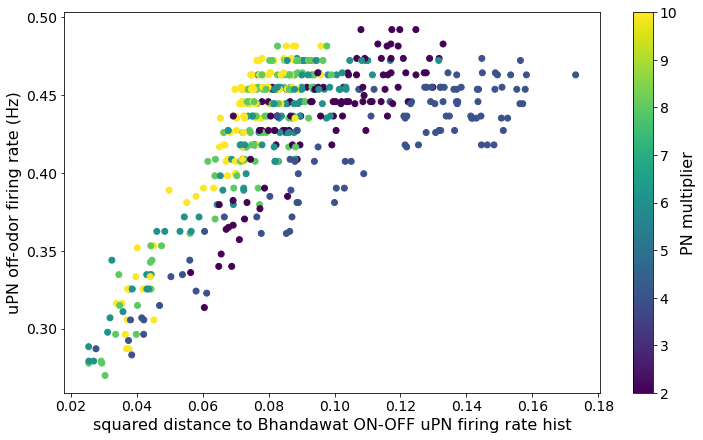

In [164]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'pn_sq_dist_bhandgloms', x_lab = 'squared distance to Bhandawat ON-OFF uPN firing rate hist',
    y_var = 'kstest_stat', y_lab = 'uPN off-odor firing rate (Hz)',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=[]
)



In [169]:
df_simvals.iloc[391-20:391+20]

,a,e,i,p,success
371,0.1,0.35,0.75,4.0,1
372,0.1,0.35,0.75,6.0,1
373,0.1,0.35,0.75,8.0,1
374,0.1,0.35,0.75,10.0,1
375,0.1,0.35,0.80,2.0,1
376,0.1,0.35,0.80,4.0,1
377,0.1,0.35,0.80,6.0,1
378,0.1,0.35,0.80,8.0,1
379,0.1,0.35,0.80,10.0,1
380,0.1,0.35,0.90,2.0,1


In [87]:
sub_df = df_res[
       #(df_res['p'] == 4) & 
       (df_res[x_var] < 0.05) &
       (df_res[y_var] < 15) &
       #(df_res['upn_off_mean'] < 20) &
       #(df_res['eln_on_mean'] < 40) &
       #(df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('upn_off_mean')[df_res_cols1].sort_values('max_upn_bhand')

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,eln_on_mean,frac_less_full,frac_less_bhand,pn_sq_dist_bhandgloms,pn_sq_dist_allgloms,mean_pca_orn_dists,std_pca_orn_dists,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists
a0.1_e0.5_i0.2_p4.0,565.046197,118.863910,280.537383,93.504112,46.216880,66.479202,63.301698,88.809643,283.25,6.736752,...,28.122760,0.812636,0.722222,0.044105,0.068523,116.913022,78.088934,220.248523,106.808077,491.910384
a0.1_e0.45_i0.2_p4.0,561.069537,118.254581,280.417160,93.802481,45.591644,66.109681,63.685957,89.131529,286.50,6.529915,...,25.291219,0.815904,0.722222,0.039716,0.075500,116.194780,77.647375,220.157914,107.310734,508.552228
a0.1_e0.3_i0.2_p4.0,566.225195,117.633535,286.758283,97.868763,44.782580,66.324000,63.459105,90.891225,289.00,5.692308,...,16.621864,0.818083,0.722222,0.043690,0.082152,117.425213,77.843352,224.940710,111.359087,483.852508
a0.1_e0.25_i0.2_p4.0,564.584218,118.725497,285.200934,96.499578,44.240418,66.089001,63.312500,90.158445,293.00,5.517949,...,13.503584,0.819172,0.712963,0.043832,0.089595,117.715915,78.788990,221.808726,111.246110,483.867013
a0.1_e0.4_i0.2_p4.0,566.496508,118.855839,285.256129,95.201347,45.694408,66.429010,64.111883,90.134273,293.00,6.052991,...,22.513441,0.816993,0.722222,0.026621,0.077460,117.330098,77.062060,221.199050,110.536663,494.742969
a0.1_e0.2_i0.2_p4.0,568.066928,119.482380,286.426757,97.480844,43.629021,66.228442,61.815586,90.639696,299.00,5.365812,...,10.224014,0.823529,0.722222,0.039178,0.089763,117.639751,77.740798,223.546464,111.501029,495.291830
a0.1_e0.35_i0.2_p4.0,568.394040,117.936114,285.012905,97.093254,45.112219,66.444472,63.020062,90.200823,305.00,5.866667,...,19.587814,0.812636,0.703704,0.038530,0.079392,117.584968,77.591758,220.694763,109.751562,501.564582
a0.1_e0.4_i0.2_p6.0,669.982874,140.147893,318.770274,101.372736,56.368233,78.437210,69.265432,100.485247,307.00,14.531624,...,25.770609,0.754902,0.675926,0.020115,0.053003,117.631435,78.154404,246.929901,116.653207,552.131329
a0.1_e0.25_i0.2_p6.0,674.283240,139.512790,323.126682,103.155703,55.472431,78.685851,66.793210,101.396118,308.50,12.579487,...,15.833333,0.760349,0.666667,0.025684,0.059437,117.169383,77.911817,248.090717,118.693960,569.001946
a0.1_e0.15_i0.2_p6.0,681.328562,138.934695,331.543858,105.154704,53.690850,78.892291,66.731481,103.598130,311.00,11.642735,...,8.409498,0.769063,0.675926,0.028176,0.068564,117.388259,77.619763,255.320731,121.189734,567.855518


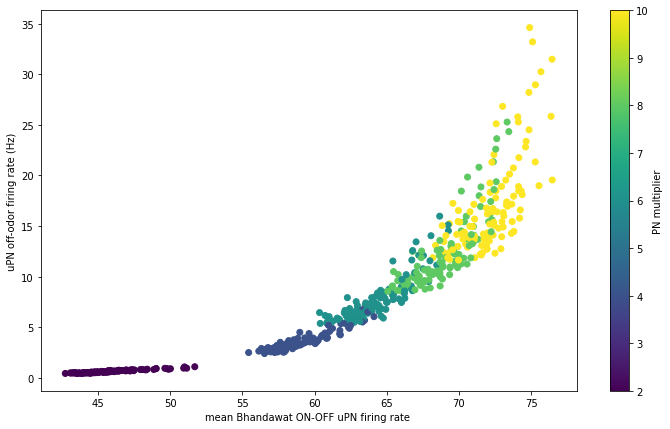

In [72]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'mean_upn_bhand', x_lab = 'mean Bhandawat ON-OFF uPN firing rate ',
    y_var = 'upn_off_mean', y_lab = 'uPN off-odor firing rate (Hz)',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=[]
)



In [73]:
sub_df = df_res[
       (df_res['p'] == 4) & 
       (df_res[x_var] > 60) &
       (df_res[y_var] < 10) &
       #(df_res['upn_off_mean'] < 20) &
       #(df_res['eln_on_mean'] < 40) &
       #(df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('upn_off_mean')[df_res_cols1].sort_values('max_pca_upn_dists')

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,pn_sq_dist_allgloms,mean_pca_orn_dists,std_pca_orn_dists,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,kstest_stat,kstest_pval
a0.1_e0.4_i0.45_p4.0,563.954670,116.339301,288.107362,99.946816,39.650626,65.258542,60.822531,91.261101,302.50,3.912821,...,0.113855,116.514218,76.693553,225.344186,112.728649,476.491828,64.0,16.0,0.380952,4.899549e-08
a0.1_e0.45_i0.3_p4.0,566.461450,117.920324,285.383310,97.802002,43.017388,66.017957,62.333333,90.365579,288.00,5.041026,...,0.093960,117.350130,77.667860,222.749638,113.014464,476.763644,60.0,24.0,0.334656,2.815533e-06
a0.1_e0.4_i0.4_p4.0,566.428712,115.459782,287.038791,98.120134,40.466467,65.538212,60.522377,90.692153,296.00,4.205128,...,0.110556,116.588458,76.888369,222.973606,111.658861,478.560876,52.0,24.0,0.371693,1.153222e-07
a0.1_e0.5_i0.3_p4.0,568.655252,118.771030,287.669949,98.321139,43.231309,66.185090,62.490741,90.913906,292.50,5.181197,...,0.093962,117.277482,77.384793,226.227176,112.067239,479.039795,60.0,28.0,0.322751,7.283579e-06
a0.1_e0.5_i0.45_p4.0,565.257295,115.285304,289.404535,99.016690,40.244712,65.414232,60.882716,91.205643,304.00,3.991453,...,0.112082,116.887285,77.706006,224.168864,112.253646,483.037003,52.0,20.0,0.380952,4.899549e-08
a0.1_e0.3_i0.2_p4.0,566.225195,117.633535,286.758283,97.868763,44.782580,66.324000,63.459105,90.891225,289.00,5.692308,...,0.082152,117.425213,77.843352,224.940710,111.359087,483.852508,80.0,24.0,0.305556,2.694667e-05
a0.1_e0.25_i0.2_p4.0,564.584218,118.725497,285.200934,96.499578,44.240418,66.089001,63.312500,90.158445,293.00,5.517949,...,0.089595,117.715915,78.788990,221.808726,111.246110,483.867013,68.0,36.0,0.306878,2.443268e-05
a0.1_e0.45_i0.45_p4.0,563.445111,116.235519,288.446435,100.147018,40.140355,65.155296,60.872685,90.832950,296.00,3.935043,...,0.116188,117.757816,78.636847,224.377109,115.127215,488.152311,64.0,24.0,0.384921,3.370900e-08
a0.1_e0.1_i0.2_p4.0,567.928504,119.383045,287.888886,99.339469,42.067633,65.871090,60.962191,90.973264,301.00,5.193162,...,0.096711,117.066497,77.918290,225.983349,113.230954,488.832101,64.0,32.0,0.341270,1.634190e-06
a0.1_e0.25_i0.3_p4.0,568.295109,117.477255,288.668828,97.561770,41.457589,65.775306,61.037809,91.054331,296.00,4.591453,...,0.106068,116.756732,77.725541,227.099240,111.441361,490.571992,60.0,28.0,0.343915,1.310404e-06


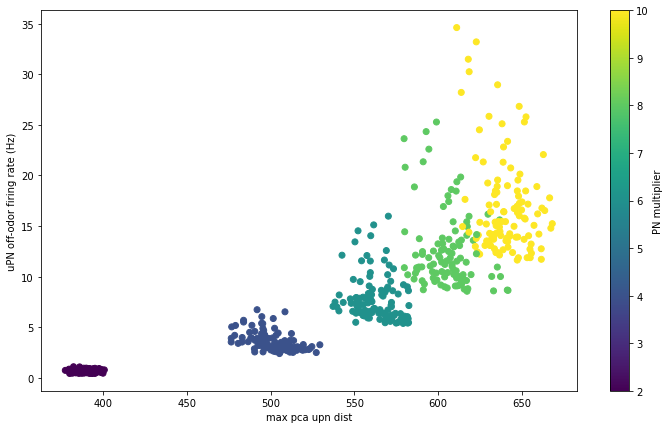

In [74]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'max_pca_upn_dists', x_lab = 'max pca upn dist',
    y_var = 'upn_off_mean', y_lab = 'uPN off-odor firing rate (Hz)',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=[]
)



In [75]:
sub_df = df_res[
       (df_res['p'] == 4) & 
       (df_res[x_var] > 60) &
       (df_res[y_var] < 10) &
       #(df_res['upn_off_mean'] < 20) &
       #(df_res['eln_on_mean'] < 40) &
       #(df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('upn_off_mean').iloc[:5][df_res_cols1]

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,pn_sq_dist_allgloms,mean_pca_orn_dists,std_pca_orn_dists,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,kstest_stat,kstest_pval
a0.1_e0.2_i1.0_p4.0,552.858937,108.953102,288.131537,105.039712,34.280120,63.028954,56.530864,91.064336,307.0,2.403419,...,0.156718,116.508889,77.800621,224.981062,120.811747,505.280632,44.0,24.0,0.464286,7.569056e-12
a0.1_e0.1_i1.0_p4.0,549.676123,109.416865,286.455778,107.769282,34.296977,62.765736,55.432870,90.734129,308.5,2.504274,...,0.158764,116.623619,76.558170,226.867257,121.894743,527.210512,60.0,12.0,0.473545,2.523870e-12
a0.1_e0.15_i1.0_p4.0,551.731958,110.612668,290.933556,106.356586,34.259300,62.982318,57.247685,91.942012,313.5,2.519658,...,0.159158,116.918873,77.209605,226.740417,122.718263,513.323961,48.0,12.0,0.462963,8.836154e-12
a0.1_e0.3_i1.0_p4.0,549.411470,110.946988,287.289997,105.014482,34.731155,62.899742,57.210648,90.762945,305.5,2.535043,...,0.159229,117.288416,77.833329,223.634167,119.441554,505.003585,44.0,20.0,0.462963,8.836154e-12
a0.1_e0.45_i1.0_p4.0,555.166969,110.801657,289.322324,105.410497,34.936610,63.339675,57.827932,91.418419,309.5,2.543590,...,0.157041,116.784564,77.358069,225.090861,119.452677,511.507046,36.0,16.0,0.445767,6.311673e-11


In [76]:
sub_df = df_res[
       (df_res['p'] == 6) & 
       #(df_res[x_var] > 60) &
       #(df_res[y_var] < 10) &
        (df_res['upn_off_mean'] < 10) &
        (df_res['mean_upn_bhand'] > 60) &
       #(df_res['eln_on_mean'] < 40) &
       #(df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('mean_pca_upn_dists')#.iloc[:5][df_res_cols1]

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,pn_sq_dist_allgloms,mean_pca_orn_dists,std_pca_orn_dists,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,kstest_stat,kstest_pval
a0.1_e0.45_i0.4_p6.0,676.514075,138.008563,326.353766,103.888703,51.604798,78.402726,67.898148,102.251237,320.5,9.509402,...,0.078448,116.817319,77.824552,251.486339,122.233677,553.421490,84.0,28.0,0.379630,5.544730e-08
a0.1_e0.45_i0.45_p6.0,672.243476,137.054119,326.295462,106.657731,50.500499,77.963141,66.725309,102.289820,319.0,8.748718,...,0.085011,116.026395,77.727896,252.864775,122.506500,560.688921,96.0,36.0,0.388889,2.309270e-08
a0.1_e0.45_i0.8_p6.0,671.220781,131.961677,330.878985,110.468858,45.282457,77.040621,63.478395,103.520776,324.5,6.441026,...,0.106555,116.890058,77.760507,253.743262,128.090018,553.764072,60.0,24.0,0.453704,2.574641e-11
a0.1_e0.25_i0.7_p6.0,672.015957,131.928933,330.912548,110.991422,45.598425,77.139325,62.357253,103.615535,320.5,6.487179,...,0.110087,116.617474,77.404382,254.934588,128.738157,553.083243,68.0,36.0,0.436508,1.755879e-10
a0.1_e0.5_i0.45_p6.0,677.427826,138.484951,329.109667,105.659870,50.844499,78.333413,66.686728,102.575736,312.5,8.970940,...,0.083084,116.737489,79.343255,254.954235,122.904828,569.858488,76.0,36.0,0.371693,1.153222e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a0.1_e0.2_i0.8_p6.0,669.468131,131.624866,337.703995,113.112020,44.444408,76.775583,62.799383,105.592011,326.0,6.100855,...,0.116396,117.884607,77.413657,263.324645,131.442311,579.808620,80.0,28.0,0.462963,8.836154e-12
a0.1_e0.4_i1.0_p6.0,668.224272,131.026949,336.176934,115.149098,43.745960,76.563100,62.477623,105.392612,326.0,5.547009,...,0.120231,117.156885,78.492830,263.422542,132.329914,579.990662,72.0,32.0,0.472222,2.957301e-12
a0.1_e0.3_i1.0_p6.0,667.381337,129.490142,339.749972,116.196038,43.579212,76.328853,62.514660,105.942615,330.0,5.473504,...,0.118667,116.743659,77.623020,264.658927,135.017359,575.798177,64.0,28.0,0.472222,2.957301e-12
a0.1_e0.35_i0.9_p6.0,676.377737,130.699705,338.339191,117.176255,44.370915,77.203186,63.385031,106.086123,330.0,5.852991,...,0.111571,117.529890,77.789855,264.878862,135.076980,582.029153,68.0,32.0,0.455026,2.213274e-11


In [77]:
sub_df = df_res[
       #(df_res['p'] == 4) & 
       #(df_res[x_var] > 60) &
       #(df_res[y_var] < 10) &
        (df_res['upn_off_mean'] < 15) &
        (df_res['mean_upn_bhand'] > 70) &
       #(df_res['eln_on_mean'] < 40) &
       #(df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('upn_off_mean')#.iloc[:5][df_res_cols1]

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,pn_sq_dist_allgloms,mean_pca_orn_dists,std_pca_orn_dists,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,kstest_stat,kstest_pval
a0.1_e0.45_i0.65_p8.0,761.933774,149.981700,367.719900,116.402345,54.638839,87.439870,70.141204,113.815945,338.0,11.246154,...,0.091788,117.707093,77.942888,283.281012,135.674545,608.248724,80.0,40.0,0.436508,1.755879e-10
a0.1_e0.5_i0.65_p8.0,759.916965,151.302897,366.290448,113.546276,55.117947,87.466515,70.557870,113.242934,334.0,11.247863,...,0.093783,116.974334,77.048235,281.112297,134.138996,597.150495,96.0,40.0,0.435185,2.028138e-10
a0.1_e0.45_i0.6_p8.0,759.200150,151.156147,364.459976,114.248963,55.436424,87.466110,70.322531,113.010869,340.5,11.832479,...,0.087808,116.935807,77.975540,281.153910,134.156891,613.222456,100.0,32.0,0.425926,5.486129e-10
a0.1_e0.5_i0.6_p8.0,758.901343,152.650656,363.470389,115.781367,55.636361,87.421488,70.813272,112.639976,348.5,11.858120,...,0.088101,117.148893,77.863273,278.584776,135.436737,607.148711,96.0,40.0,0.407407,3.733094e-09
a0.1_e0.3_i1.0_p10.0,820.293131,159.168640,391.790576,125.699995,54.984159,93.526530,71.093364,120.853607,354.5,11.876923,...,0.102630,118.152392,78.332048,302.248946,149.488602,654.839859,92.0,40.0,0.473545,2.523870e-12
a0.1_e0.4_i1.0_p10.0,814.863279,155.991329,386.932878,121.883187,55.252120,93.025814,71.545525,119.154408,344.0,12.140171,...,0.101940,116.106177,77.522681,299.239760,145.877621,636.528443,88.0,48.0,0.464286,7.569056e-12
a0.1_e0.35_i1.0_p10.0,818.362369,157.917426,389.466814,120.812751,55.040768,93.349718,71.479938,119.960210,348.0,12.220513,...,0.105215,117.022045,78.294032,301.068833,143.061481,624.700273,84.0,44.0,0.472222,2.957301e-12
a0.1_e0.45_i1.0_p10.0,822.644920,157.729042,391.913354,123.408581,55.653404,93.813252,72.489198,121.029936,348.0,12.317949,...,0.110442,116.664054,76.967936,301.185885,146.508128,655.538083,88.0,36.0,0.462963,8.836154e-12
a0.1_e0.5_i1.0_p10.0,819.105378,160.872638,391.550099,121.935908,55.848502,93.735677,71.623457,120.709019,334.5,12.365812,...,0.110070,116.786849,77.443938,301.775384,144.690821,635.787882,88.0,28.0,0.462963,8.836154e-12
a0.1_e0.4_i0.9_p10.0,822.940397,158.486789,391.493311,125.361852,56.428890,94.087933,71.932870,120.859896,354.5,12.719658,...,0.099014,117.284438,78.085588,301.188356,150.088244,654.687529,92.0,56.0,0.462963,8.836154e-12


In [78]:
df_res.loc['a0.1_e0.5_i0.4_p10.0']

mean_upn_onoff_dists     8.191035e+02
std_upn_onoff_dists      1.633668e+02
mean_upn_bhand_dists     3.767668e+02
std_upn_bhand_dists      1.107510e+02
mean_upn_onoff           6.490664e+01
std_upn_onoff            9.452008e+01
mean_upn_bhand           7.527701e+01
std_upn_bhand            1.164327e+02
max_upn_bhand            3.370000e+02
upn_off_mean             2.133504e+01
iln_off_mean             3.626506e+00
iln_on_mean              1.166499e+01
eln_off_mean             8.903226e+00
eln_on_mean              2.923387e+01
a                        1.000000e-01
e                        5.000000e-01
i                        4.000000e-01
p                        1.000000e+01
frac_less_full           7.091503e-01
frac_less_bhand          6.203704e-01
pn_sq_dist_bhandgloms    5.038764e-02
pn_sq_dist_allgloms      4.808291e-02
mean_pca_orn_dists       1.165263e+02
std_pca_orn_dists        7.738725e+01
mean_pca_upn_dists       2.844653e+02
std_pca_upn_dists        1.359089e+02
max_pca_upn_

In [79]:
df_res.columns

Index(['mean_upn_onoff_dists', 'std_upn_onoff_dists', 'mean_upn_bhand_dists',
       'std_upn_bhand_dists', 'mean_upn_onoff', 'std_upn_onoff',
       'mean_upn_bhand', 'std_upn_bhand', 'max_upn_bhand', 'upn_off_mean',
       'iln_off_mean', 'iln_on_mean', 'eln_off_mean', 'eln_on_mean', 'a', 'e',
       'i', 'p', 'frac_less_full', 'frac_less_bhand', 'pn_sq_dist_bhandgloms',
       'pn_sq_dist_allgloms', 'mean_pca_orn_dists', 'std_pca_orn_dists',
       'mean_pca_upn_dists', 'std_pca_upn_dists', 'max_pca_upn_dists',
       'DM1_PN_pre_odor_fr', 'VA2_PN_pre_odor_fr', 'kstest_stat',
       'kstest_pval'],
      dtype='object')

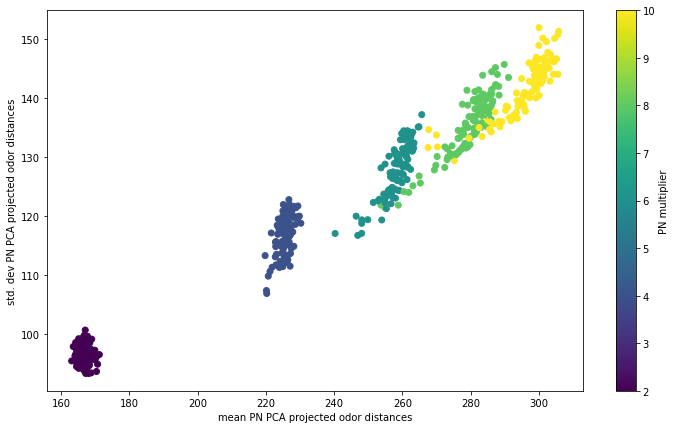

In [80]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'mean_pca_upn_dists', x_lab = 'mean PN PCA projected odor distances',
    y_var = 'std_pca_upn_dists', y_lab = 'std. dev PN PCA projected odor distances',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=[]
)



In [81]:
sub_df = df_res[
       #(df_res['p'] == 6) & 
       (df_res[x_var] < 0.73) &
       (df_res[y_var] < 20) &
       #(df_res['upn_off_mean'] < 20) &
       #(df_res['eln_on_mean'] < 40) &
       #(df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('upn_off_mean').iloc[:5][df_res_cols1]

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,pn_sq_dist_allgloms,mean_pca_orn_dists,std_pca_orn_dists,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,kstest_stat,kstest_pval


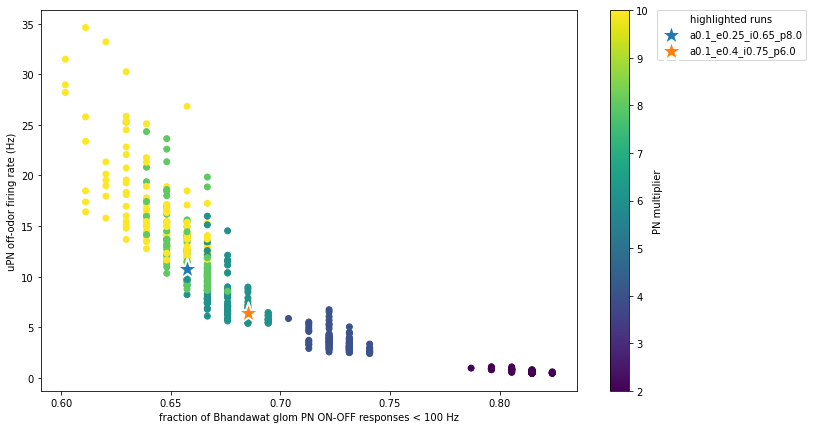

In [82]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'frac_less_bhand', x_lab = 'fraction of Bhandawat glom PN ON-OFF responses < 100 Hz',
    y_var = 'upn_off_mean', y_lab = 'uPN off-odor firing rate (Hz)',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
                 'a0.1_e0.4_i0.75_p6.0']
)



In [83]:
sub_df = df_res[
       #(df_res['p'] == 6) & 
       (df_res[x_var] < 0.7) &
       (df_res[y_var] < 20) &
       (df_res['upn_off_mean'] < 20) &
       (df_res['eln_on_mean'] < 40) &
        (df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('upn_off_mean').iloc[:5][df_res_cols1]

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,pn_sq_dist_allgloms,mean_pca_orn_dists,std_pca_orn_dists,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,kstest_stat,kstest_pval
a0.1_e0.1_i1.0_p6.0,665.536177,127.433081,335.691346,115.780241,42.656177,76.002476,60.388117,105.017217,330.0,5.381197,...,0.122569,117.157503,78.224406,261.471543,134.396519,579.047905,56.0,36.0,0.473545,2.523870e-12
a0.1_e0.25_i1.0_p6.0,665.543281,131.216661,334.868372,117.026182,43.339284,76.097793,60.834105,104.852360,322.0,5.413675,...,0.124504,118.035529,77.910762,262.600913,133.579838,581.738120,68.0,32.0,0.481481,9.650059e-13
a0.1_e0.2_i1.0_p6.0,666.363258,130.226038,335.990277,114.741450,43.058678,76.181018,62.028549,104.873461,330.0,5.415385,...,0.120754,117.508351,77.752345,260.768567,133.174441,574.855239,60.0,32.0,0.455026,2.213274e-11
a0.1_e0.15_i1.0_p6.0,664.419834,129.716234,333.151841,116.007566,42.732816,75.913585,61.125000,104.339498,322.0,5.449573,...,0.122538,116.994705,77.879742,260.384274,134.386081,568.293370,60.0,32.0,0.472222,2.957301e-12
a0.1_e0.35_i1.0_p6.0,668.200112,130.953896,334.676692,114.843284,43.708637,76.417132,62.584877,105.006210,330.0,5.461538,...,0.126423,117.586664,77.515291,263.066434,131.576166,582.263526,56.0,36.0,0.472222,2.957301e-12


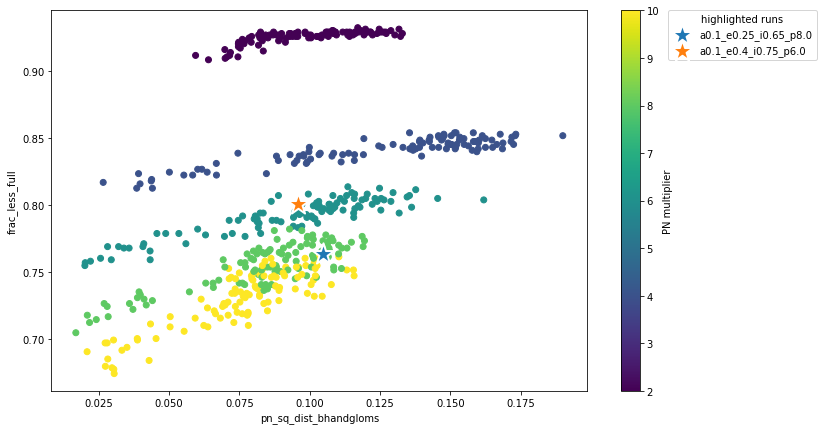

In [84]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'pn_sq_dist_bhandgloms',
    y_var = 'frac_less_full',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
                 'a0.1_e0.4_i0.75_p6.0']
)



In [85]:
df_res[(df_res['e'] == 0.3) & (df_res['i'] == 0.45) & (df_res['p'] == 4)]

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,pn_sq_dist_allgloms,mean_pca_orn_dists,std_pca_orn_dists,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,kstest_stat,kstest_pval
a0.1_e0.3_i0.45_p4.0,563.11202,114.590423,286.364879,100.857136,39.190232,64.989983,60.157407,90.786504,300.0,3.750427,...,0.11741,116.206078,78.256519,225.181354,114.595512,496.13135,56.0,32.0,0.362434,2.652498e-07


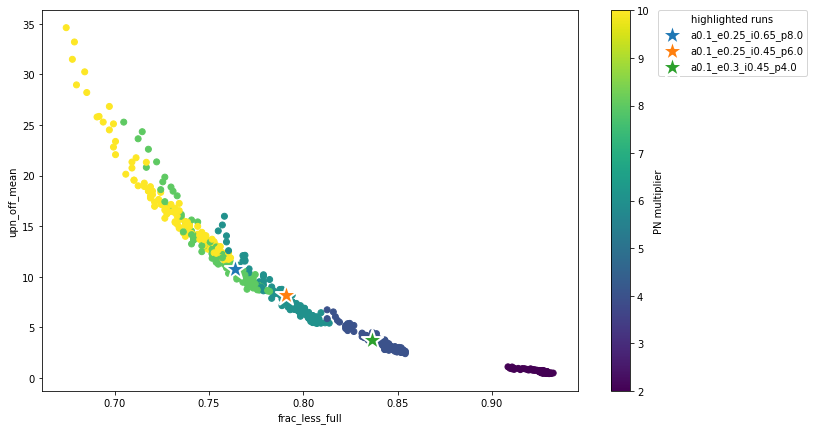

In [86]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'frac_less_full',
    y_var = 'upn_off_mean',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
                    'a0.1_e0.25_i0.45_p6.0',
                    'a0.1_e0.3_i0.45_p4.0']
)



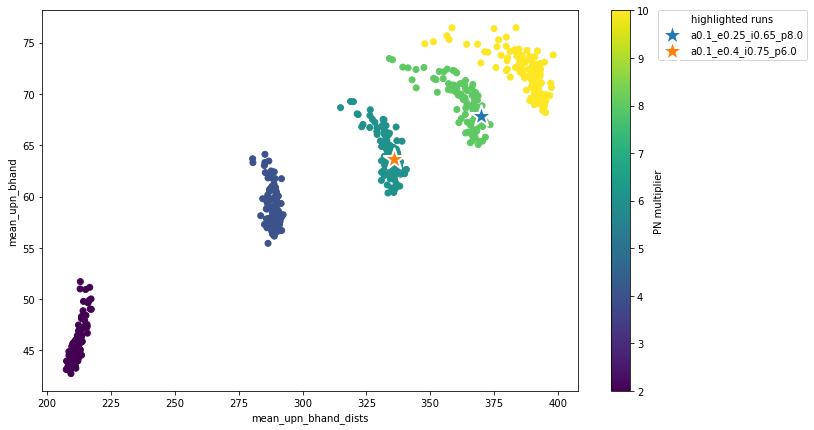

In [87]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'mean_upn_bhand_dists',
    y_var = 'mean_upn_bhand',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
                 'a0.1_e0.4_i0.75_p6.0']
    #highlight_locs=['a0.1_e0.25_i0.65_p8.0', 'a0.1_e0.25_i0.45_p6.0']
)

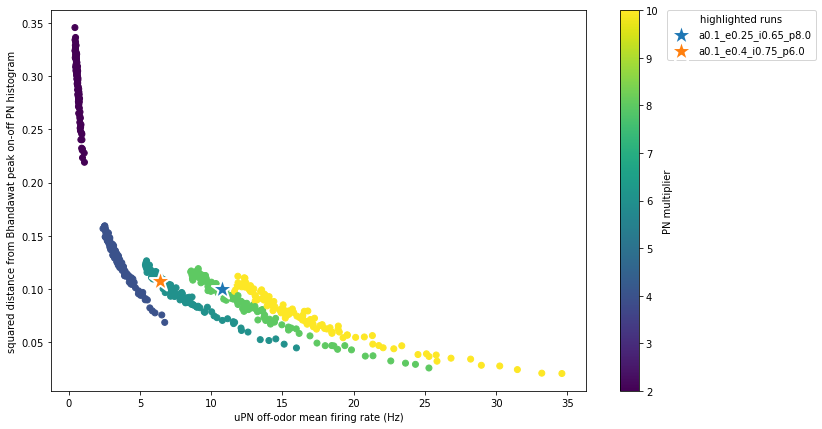

In [88]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'upn_off_mean', x_lab='uPN off-odor mean firing rate (Hz)',
    y_var = 'pn_sq_dist_allgloms', y_lab='squared distance from Bhandawat peak on-off PN histogram',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
                 'a0.1_e0.4_i0.75_p6.0'])

In [89]:
sub_df = df_res[
       #(df_res['p'] == 6) & 
       (df_res[x_var] < 20) &
       (df_res[y_var] < 0.03) &
       (1) ]
sub_df.sort_values('upn_off_mean')

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,pn_sq_dist_allgloms,mean_pca_orn_dists,std_pca_orn_dists,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,kstest_stat,kstest_pval


In [ ]:
sub_df = df_res[
       #(df_res['p'] == 6) & 
       (df_res[x_var] < 20) &
       (df_res[y_var] < 0.05) &
       (1) ]
sub_df.sort_values('pn_sq_dist')

In [ ]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'upn_off_mean', x_lab='uPN off-odor mean firing rate (Hz)',
    y_var = 'mean_upn_bhand', y_lab='mean uPN Bhandawat odor distance',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
                    'a0.1_e0.25_i0.45_p6.0',
                    'a0.1_e0.3_i0.45_p4.0'])

In [ ]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'upn_off_mean', x_lab='uPN off-odor mean firing rate (Hz)',
    y_var = 'frac_less_full', y_lab='fraction of olfactory glomerular responses < 100 Hz (~uniformity?)',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
                    'a0.1_e0.25_i0.45_p6.0',
                    'a0.1_e0.3_i0.45_p4.0']
)

In [ ]:
sub_df = df_res[
       #(df_res['p'] == 6) & 
       (df_res[x_var] < 20) &
       (df_res[y_var] < 0.7) &
       (1) ]
sub_df.sort_values('upn_off_mean')

In [ ]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'upn_off_mean', x_lab='uPN off-odor mean firing rate (Hz)',
    y_var = 'mean_upn_bhand_dists', y_lab='mean uPN Bhandawat odor distance',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
                    'a0.1_e0.25_i0.45_p6.0',
                    'a0.1_e0.3_i0.45_p4.0'])

In [ ]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'upn_off_mean', x_lab='uPN off-odor mean firing rate (Hz)',
    y_var = 'mean_upn_bhand', y_lab='mean uPN Bhandawat on-off',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
                    'a0.1_e0.25_i0.45_p6.0',
                    'a0.1_e0.3_i0.45_p4.0'])

In [ ]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'upn_off_mean', x_lab='uPN off-odor mean firing rate (Hz)',
    y_var = 'frac_less_full', y_lab='mean uPN Bhandawat on-off',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
                    'a0.1_e0.25_i0.45_p6.0',
                    'a0.1_e0.3_i0.45_p4.0'])

In [ ]:
sub_df = df_res[
       (df_res['p'] == 6) & 
       (df_res[x_var] < 20) &
       (df_res[y_var] < 95) &
       (1) ]
sub_df.sort_values('upn_off_mean')

In [ ]:
df_res

In [ ]:
df_compare = df_res.copy().loc[['a0.1_e0.25_i0.65_p8.0', 'a0.1_e0.25_i0.45_p6.0']][
    ['mean_upn_bhand_dists', 'mean_upn_bhand', 'upn_off_mean', 'frac_less_bhand', 'eln_on_mean', 'iln_on_mean']]
df_compare.columns = ['mean Bhandawat PN inter-odor distance', 'mean PN Bhandawat glom. on - off odor', 
                      'PN off-odor mean', 'frac Bhandawat glom < 100 hz',
                      'eLN on-odor mean', 'iLN on-odor mean']
df_compare

In [ ]:
df_res.loc['a0.1_e0.25_i0.45_p6.0']

In [ ]:
sub_df = df_res[
    (df_res.mean_upn_bhand < 100) & 
    (df_res.upn_off_mean < 15) & 
    #(df_res.mean_upn_bhand < 90) & 
    #(df_res.frac_less_full < 0.7) & 
    #(df_res.mean_upn_bhand_dists < 400) & 
       (1)]
sub_df.sort_values('frac_less_full')

In [ ]:
sub_df = df_res[
    (df_res.mean_upn_bhand < 95) & 
    (df_res.upn_off_mean < 15) & 
    #(df_res.mean_upn_bhand < 90) & 
    #(df_res.frac_less_full < 0.7) & 
    #(df_res.mean_upn_bhand_dists < 400) & 
       (1)]
sub_df.sort_values('frac_less_full')

In [ ]:
sub_df = df_res[
    (df_res.mean_upn_bhand_dists < 400) & 
    (df_res.upn_off_mean < 10) & 
    #(df_res.mean_upn_bhand < 90) & 
    #(df_res.frac_less_full < 0.7) & 
    #(df_res.mean_upn_bhand_dists < 400) & 
       (1)]
sub_df.sort_values('frac_less_full')

In [ ]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'mean_upn_onoff', x_lab='', 
    y_var = 'mean_upn_bhand_dists', y_lab='',
    c_var = 'p', c_lab='',
    highlight_locs=['a0.1_e0.25_i0.65_p8.0', 'a0.1_e0.3_i0.45_p4.0'])

In [ ]:
df_res[df_res]

In [ ]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'frac_less_full',
    y_var = 'mean_upn_bhand_dists',
    c_var = 'p')

In [ ]:
df_res[
       (df_res['p'] == 8) & 
    (df_res['frac_less_full'] < 0.68) &
    #(df_res['frac_less_bhand'] < 0.56) &
    (df_res['eln_off_mean'] < 15) &
    (df_res['iln_off_mean'] < 15) &
    #(df_res[x_var] < 0.68) &
       #(df_res[y_var]  10) &
       (1) ].sort_values('upn_off_mean')

In [ ]:
df_res[]

In [ ]:
df_res[
       (df_res['p'] == 8) & 
       (df_res['mean_upn_bhand_dists'] < 450) &
       (df_res['eln_on_mean'] < 25) &
       (1) ].sort_values('mean_upn_bhand_dists')

In [ ]:
df_res[
       (df_res['p'] == 8) & 
       (df_res[x_var] < 5) &
       #(df_res[y_var]  10) &
       (1) ]

In [ ]:
plt.hist(df_res['mean_upn_bhand'])

In [ ]:
plt.hist(df_res['mean_upn_bhand_dists'])

In [ ]:
df_res[df_res['eln_on_mean'] < 40]

In [ ]:
df_res[
       (df_res['p'] == 6) & 
       #(df_res[x_var] > 700) & 
       (df_res[x_var] > 70) & 
       (1) ]

In [ ]:
df_res.sort_values('eln_on_mean')

In [ ]:
plt.figure()
plt.hist(df_res['mean_upn_onoff'])
plt.show()

In [ ]:
plt.figure()
plt.scatter(df_res['p'], df_res['mean_upn_onoff'])
plt.show()

In [ ]:
df_res

In [ ]:
#df_res.to_csv('df_res21.csv')

In [ ]:
df_res

In [ ]:
foo

In [ ]:
res_d

In [ ]:
plot_AL_activity_dur_pre_odors(df_AL_activity_long)

In [ ]:
df_rest = pd.concat((df_res, df_res2), 1)

In [ ]:
df_rest

In [ ]:
df_rest[(df_rest['mean_upn_bhand'] < 150) & 
        (df_rest['mean_upn_bhand_dists'] < 350)]

In [ ]:
df_res = pd.DataFrame.from_dict(res_d).T

In [ ]:
df_res.to_csv('df_res1.csv')

In [ ]:
df_res

In [ ]:
foo

In [ ]:
df_orn_glom_onoff_bhand, df_upn_glom_onoff_bhand = \
        make_glomerular_odor_responses(df_orn_frs_bhand, df_upn_frs_bhand, df_AL_activity_bhand)

In [ ]:
df_AL_activity_bhand.shape

In [ ]:
df_orn_frs_bhand = df_orn_frs.loc[bhand_gloms]
df_upn_frs_bhand = df_upn_frs.loc[bhand_gloms]

In [ ]:
foo

In [ ]:
odv = orn_table.T.values; pdv = pn_table.T.values
maxz = max(np.max(odv), np.max(pdv)); minz = min(np.min(odv), np.min(pdv))
orn_dists = pdist(odv, metric='euclidean'); pn_dists = pdist(pdv, metric='euclidean')

In [ ]:
mindist = min(min(orn_dists), min(pn_dists)); maxdist = max(max(orn_dists), max(pn_dists))

In [ ]:
mindist, maxdist

In [ ]:
b = np.linspace(mindist, maxdist, 12)  
plt.hist(orn_dists, label='ORN', alpha=0.6, bins=b, color='xkcd:light blue')
plt.hist(pn_dists, label='PN', alpha=0.6, bins=b, color='xkcd:navy')

In [ ]:
mindist, maxdist

In [ ]:
df_orn_glom_onoff

In [ ]:
orn_table = (df_durs_orns - np.mean(df_durs_orns.values)).T / np.std(df_durs_orns.values)
pn_table = (df_durs_upns - np.mean(df_durs_upns.values)).T / np.std(df_durs_upns.values)

In [ ]:
df_orn_glom_onoff

In [ ]:
foo

In [ ]:
orn_table = df_orn_glom_onoff; pn_table = df_upn_glom_onoff

orn_dists = pdist(orn_table)

In [ ]:
odv = orn_table.T.values
pdv = pn_table.T.values

In [ ]:
orn_dists = pdist(odv, metric='euclidean'); pn_dists = pdist(pdv, metric='euclidean')

In [ ]:
foo

In [ ]:
plt.hist(df_upn_glom_onoff.values.flatten())

In [ ]:
foo

In [ ]:
np.any (df_upn_frs < 0)

In [ ]:
np.any(df_durs_upns < 0)

In [ ]:
def add_glom_changepts(glom_changepts, glom_list):
    '''
    Utility for plotting as heatmap
    '''
    for i in range(len(glom_changepts)-1):
        g1, g2 = glom_changepts[i:i+2]
        plt.fill_betweenx([0,1],x1=g1, x2=g2)
        plt.text((g1+g2)/2, 0., '{} ({})'.format(glom_list.iloc[g1], g2-g1), ha='center', va='top', rotation=90)
        
def plot_fig_orn_pn(fig_orn_pn, sim, Spikes):
            
    # get firing rate info
    df_AL_activity, df_AL_activity_long = get_AL_activity_dfs(sim, Spikes)
    df_orn_frs, df_pn_frs, max_fr = get_orn_pn_frs_from_df_AL_activity(df_AL_activity, sim)
    df_char_ids = sim.df_char_ids.copy()
    
    cbar_ax = fig_orn_pn.add_axes([.91, .4, .03, .4])
    
    gs = GridSpec(7, 3, height_ratios=[6,1,3,6,1,3,7], width_ratios=[2,2,1])
    
    # ORN heatmap
    ax1 = plt.subplot(gs[0, :])
    ax1.set_title('Firing rates during odors of all ORNs, grouped by glomerulus')
    sns.heatmap(df_orn_frs.T, ax=ax1, cbar_ax=cbar_ax,
                fmt='.0f', cmap='viridis', vmin=0, vmax=max_fr*1.05)
    ax2 = plt.subplot(gs[1, :], sharex=ax1)
    orn_gloms = df_char_ids[df_char_ids.altype=='ORN']['glom']
    glom_changepts = np.append(np.where(~orn_gloms.duplicated())[0], len(orn_gloms))
    add_glom_changepts(glom_changepts, orn_gloms)
    
    # filler
    axf = plt.subplot(gs[2, :])
    axf.set_visible(False)
   
    # PN heatmap
    ax3 = plt.subplot(gs[3, :])
    ax3.set_title('Firing rates during odors of all uPNs, grouped by glomerulus')
    sns.heatmap(df_pn_frs.T, ax=ax3, cbar_ax=cbar_ax,
                fmt='.0f', cmap='viridis', vmin=0, vmax=max_fr*1.05)
    ax4 = plt.subplot(gs[4, :], sharex=ax3)
    pn_gloms = df_char_ids[df_char_ids.altype2=='uPN']['glom']
    glom_changepts = np.append(np.where(~pn_gloms.duplicated())[0], len(pn_gloms))
    add_glom_changepts(glom_changepts, pn_gloms)
    
    # cosmetics
    for ax in [ax1, ax3]:
        ax.set_label(''); ax.set_xticks([]); 
        ax.yaxis.set_tick_params(rotation=45)
        b, t = ax.get_ylim()
        ax.set_ylim(b+0.5, t-0.5)
    for ax in [ax2, ax4]:
        ax.set_yticks([])
        
    # filler
    axf = plt.subplot(gs[5, :])
    axf.set_visible(False)

    # plot firing rates PN vs ORN
    ax5 = plt.subplot(gs[6,0])
    plot_sim_ORN_PN_firing_rates(sim, df_AL_activity)
    plt.title('Mean glom PN vs. ORN frs')
    plt.legend(bbox_to_anchor=(1.05, -0.2), title=r'odors (mean $\pm$ sd)')
    
    # plot euclidean distances
    ax6 = plt.subplot(gs[6,1])
    plt.title('Distance b/w odor pairs in PN/ORN space')
    dur_odor_cols = df_AL_activity.columns[df_AL_activity.columns.str.startswith('fr_dur_odor')].values
    df_durs = df_AL_activity.groupby(['neur_type2', 'glom']).mean()[dur_odor_cols].reset_index()
    df_durs_orns = df_durs[df_durs.neur_type2 == 'ORN'].set_index('glom')[dur_odor_cols].loc[sim.glom_names]
    df_durs_upns = df_durs[df_durs.neur_type2 == 'uPN'].set_index('glom')[dur_odor_cols].loc[sim.glom_names]
    odv = df_durs_orns.T.values; odv /= np.max(odv)
    pdv = df_durs_upns.T.values; pdv = np.nan_to_num(pdv/np.max(pdv), 0)
    orn_dists = pdist(odv, metric='euclidean'); pn_dists = pdist(pdv, metric='euclidean')
    plt.hist(orn_dists, label='ORN', alpha=0.6, color='xkcd:light blue')
    plt.hist(pn_dists, label='PN', alpha=0.6, color='xkcd:navy')
    plt.xlabel('pairwise euclidean distance')
    plt.ylabel('# odor pairs')
    plt.legend()

    # plot as scatter plot
    ax7 = plt.subplot(gs[6,2])
    minx = min(min(orn_dists), min(pn_dists))
    maxx = max(max(orn_dists), max(pn_dists))
    plt.scatter(orn_dists, pn_dists, color='k')
    plt.plot([minx, maxx], [minx, maxx], color='0.5', ls='--')
    plt.xlabel('ORN pairwise distance'); plt.ylabel('PN pairwise distance')
    
    plt.subplots_adjust(hspace=0)

In [ ]:
def add_glom_changepts(glom_changepts, glom_list):
    '''
    Utility for plotting as heatmap
    '''
    for i in range(len(glom_changepts)-1):
        g1, g2 = glom_changepts[i:i+2]
        plt.fill_betweenx([0,1],x1=g1, x2=g2)
        plt.text((g1+g2)/2, 0., '{} ({})'.format(glom_list.iloc[g1], g2-g1), ha='center', va='top', rotation=90)
        
def plot_fig_orn_pn(fig_orn_pn, sim, Spikes):
            
    # get firing rate info
    df_AL_activity, df_AL_activity_long = get_AL_activity_dfs(sim, Spikes)
    df_orn_frs, df_pn_frs, max_fr = get_orn_pn_frs_from_df_AL_activity(df_AL_activity, sim)
    df_char_ids = sim.df_char_ids.copy()
    
    cbar_ax = fig_orn_pn.add_axes([.91, .4, .03, .4])
    
    gs = GridSpec(7, 3, height_ratios=[6,1,3,6,1,3,7], width_ratios=[2,2,1])
    
    # ORN heatmap
    ax1 = plt.subplot(gs[0, :])
    ax1.set_title('Firing rates during odors of all ORNs, grouped by glomerulus')
    sns.heatmap(df_orn_frs.T, ax=ax1, cbar_ax=cbar_ax,
                fmt='.0f', cmap='viridis', vmin=0, vmax=max_fr*1.05)
    ax2 = plt.subplot(gs[1, :], sharex=ax1)
    orn_gloms = df_char_ids[df_char_ids.altype=='ORN']['glom']
    glom_changepts = np.append(np.where(~orn_gloms.duplicated())[0], len(orn_gloms))
    add_glom_changepts(glom_changepts, orn_gloms)
    
    # filler
    axf = plt.subplot(gs[2, :])
    axf.set_visible(False)
   
    # PN heatmap
    ax3 = plt.subplot(gs[3, :])
    ax3.set_title('Firing rates during odors of all uPNs, grouped by glomerulus')
    sns.heatmap(df_pn_frs.T, ax=ax3, cbar_ax=cbar_ax,
                fmt='.0f', cmap='viridis', vmin=0, vmax=max_fr*1.05)
    ax4 = plt.subplot(gs[4, :], sharex=ax3)
    pn_gloms = df_char_ids[df_char_ids.altype2=='uPN']['glom']
    glom_changepts = np.append(np.where(~pn_gloms.duplicated())[0], len(pn_gloms))
    add_glom_changepts(glom_changepts, pn_gloms)
    
    # cosmetics
    for ax in [ax1, ax3]:
        ax.set_label(''); ax.set_xticks([]); 
        ax.yaxis.set_tick_params(rotation=45)
        b, t = ax.get_ylim()
        ax.set_ylim(b+0.5, t-0.5)
    for ax in [ax2, ax4]:
        ax.set_yticks([])
        
    # filler
    axf = plt.subplot(gs[5, :])
    axf.set_visible(False)

    # plot firing rates PN vs ORN
    ax5 = plt.subplot(gs[6,0])
    plot_sim_ORN_PN_firing_rates(sim, df_AL_activity)
    plt.title('Mean glom PN vs. ORN frs')
    plt.legend(bbox_to_anchor=(1.05, -0.2), title=r'odors (mean $\pm$ sd)')
    
    # plot euclidean distances
    ax6 = plt.subplot(gs[6,1])
    plt.title('Distance b/w odor pairs in PN/ORN space')
    dur_odor_cols = df_AL_activity.columns[df_AL_activity.columns.str.startswith('fr_dur_odor')].values
    df_durs = df_AL_activity.groupby(['neur_type2', 'glom']).mean()[dur_odor_cols].reset_index()
    df_durs_orns = df_durs[df_durs.neur_type2 == 'ORN'].set_index('glom')[dur_odor_cols].loc[sim.glom_names]
    df_durs_upns = df_durs[df_durs.neur_type2 == 'uPN'].set_index('glom')[dur_odor_cols].loc[sim.glom_names]
    odv = df_durs_orns.T.values; odv /= np.max(odv)
    pdv = df_durs_upns.T.values; pdv = np.nan_to_num(pdv/np.max(pdv), 0)
    orn_dists = pdist(odv, metric='euclidean'); pn_dists = pdist(pdv, metric='euclidean')
    plt.hist(orn_dists, label='ORN', alpha=0.6, color='xkcd:light blue')
    plt.hist(pn_dists, label='PN', alpha=0.6, color='xkcd:navy')
    plt.xlabel('pairwise euclidean distance')
    plt.ylabel('# odor pairs')
    plt.legend()

    # plot as scatter plot
    ax7 = plt.subplot(gs[6,2])
    minx = min(min(orn_dists), min(pn_dists))
    maxx = max(max(orn_dists), max(pn_dists))
    plt.scatter(orn_dists, pn_dists, color='k')
    plt.plot([minx, maxx], [minx, maxx], color='0.5', ls='--')
    plt.xlabel('ORN pairwise distance'); plt.ylabel('PN pairwise distance')
    
    plt.subplots_adjust(hspace=0)

In [ ]:
def add_glom_changepts(glom_changepts, glom_list):
    '''
    Utility for plotting as heatmap
    '''
    for i in range(len(glom_changepts)-1):
        g1, g2 = glom_changepts[i:i+2]
        plt.fill_betweenx([0,1],x1=g1, x2=g2)
        plt.text((g1+g2)/2, 0., '{} ({})'.format(glom_list.iloc[g1], g2-g1), ha='center', va='top', rotation=90)
        

In [ ]:
fig_orn_pn = plt.figure(figsize=(12,12))

df_pn_frs = df_upn_frs
    
cbar_ax = fig_orn_pn.add_axes([.91, .4, .03, .4])

gs = GridSpec(7, 3, height_ratios=[6,1,3,6,1,3,7], width_ratios=[2,2,1])

max_fr = max(np.max(np.max(df_orn_frs)), np.max(np.max(df_upn_frs)))

# ORN heatmap
ax1 = plt.subplot(gs[0, :])
ax1.set_title('Firing rates during odors of all ORNs, grouped by glomerulus')
sns.heatmap(df_orn_frs.T, ax=ax1, cbar_ax=cbar_ax,
            fmt='.0f', cmap='viridis', vmin=0, vmax=max_fr*1.05)
ax2 = plt.subplot(gs[1, :], sharex=ax1)
orn_gloms = df_char_ids[df_char_ids.altype=='ORN']['glom']
glom_changepts = np.append(np.where(~orn_gloms.duplicated())[0], len(orn_gloms))
add_glom_changepts(glom_changepts, orn_gloms)

# filler
axf = plt.subplot(gs[2, :])
axf.set_visible(False)

# PN heatmap
ax3 = plt.subplot(gs[3, :])
ax3.set_title('Firing rates during odors of all uPNs, grouped by glomerulus')
sns.heatmap(df_pn_frs.T, ax=ax3, cbar_ax=cbar_ax,
            fmt='.0f', cmap='viridis', vmin=0, vmax=max_fr*1.05)
ax4 = plt.subplot(gs[4, :], sharex=ax3)
pn_gloms = df_char_ids[df_char_ids.altype2=='uPN']['glom']
glom_changepts = np.append(np.where(~pn_gloms.duplicated())[0], len(pn_gloms))
add_glom_changepts(glom_changepts, pn_gloms)

# cosmetics
for ax in [ax1, ax3]:
    ax.set_label(''); ax.set_xticks([]); 
    ax.yaxis.set_tick_params(rotation=45)
    b, t = ax.get_ylim()
    ax.set_ylim(b+0.5, t-0.5)
for ax in [ax2, ax4]:
    ax.set_yticks([])

# filler
axf = plt.subplot(gs[5, :])
axf.set_visible(False)

# plot firing rates PN vs ORN
ax5 = plt.subplot(gs[6,0])
plot_sim_ORN_PN_firing_rates(sim, df_AL_activity)
plt.title('Mean glom PN vs. ORN frs')
plt.legend(bbox_to_anchor=(1.05, -0.2), title=r'odors (mean $\pm$ sd)')

# plot euclidean distances
ax6 = plt.subplot(gs[6,1])
plt.title('Distance b/w odor pairs in PN/ORN space')
dur_odor_cols = df_AL_activity.columns[df_AL_activity.columns.str.startswith('fr_dur_odor')].values
df_durs = df_AL_activity.groupby(['neur_type2', 'glom']).mean()[dur_odor_cols].reset_index()
df_durs_orns = df_durs[df_durs.neur_type2 == 'ORN'].set_index('glom')[dur_odor_cols].loc[sim.glom_names]
df_durs_upns = df_durs[df_durs.neur_type2 == 'uPN'].set_index('glom')[dur_odor_cols].loc[sim.glom_names]
odv = df_durs_orns.T.values; odv /= np.max(odv)
pdv = df_durs_upns.T.values; pdv = np.nan_to_num(pdv/np.max(pdv), 0)
orn_dists = pdist(odv, metric='euclidean'); pn_dists = pdist(pdv, metric='euclidean')
plt.hist(orn_dists, label='ORN', alpha=0.6, color='xkcd:light blue')
plt.hist(pn_dists, label='PN', alpha=0.6, color='xkcd:navy')
plt.xlabel('pairwise euclidean distance')
plt.ylabel('# odor pairs')
plt.legend()

# plot as scatter plot
ax7 = plt.subplot(gs[6,2])
minx = min(min(orn_dists), min(pn_dists))
maxx = max(max(orn_dists), max(pn_dists))
plt.scatter(orn_dists, pn_dists, color='k')
plt.plot([minx, maxx], [minx, maxx], color='0.5', ls='--')
plt.xlabel('ORN pairwise distance'); plt.ylabel('PN pairwise distance')

plt.subplots_adjust(hspace=0)

plt.show()

In [ ]:
########## OLD
sub_pre = True
olf_only = True
for i in range(njobs):
    
    runvals= dfpick[i]['simvals']
    df_AL_activity = dfpick[i]['df_AL_activity']
    
    df_AL_activity_long = make_df_AL_activity_long(df_AL_activity)
    # remove non olfactory glomeruli
    df_AL_activity_long = df_AL_activity_long[~df_AL_activity_long.glom.isin(thermo_hygro_glomeruli)]
    
    
    st = 'a{}_e{}_i{}_p{}'.format(*runvals)
    
    # use same binning as Bhandawat histogram    

    df_orn_activity = df_AL_activity.loc[df_AL_activity.neur_type == 'ORN'].set_index('neur_name')
    df_orn_frs = df_orn_activity.loc[:, df_orn_activity.columns.str.contains('dur')]
    df_orn_frs.columns = odor_names

    df_upn_activity = df_AL_activity.loc[df_AL_activity.neur_type2 == 'uPN'].set_index('neur_name')
    df_upn_frs = df_upn_activity.loc[:, df_upn_activity.columns.str.contains('dur')]
    df_upn_frs.columns = odor_names
    
    max_fr = max(np.max(np.max(df_orn_frs)), np.max(np.max(df_upn_frs)))
    
    if sub_pre:
        orn_frs_pre = df_orn_activity.loc[:, df_orn_activity.columns.str.contains('pre')].values
        df_orn_frs -= orn_frs_pre
        upn_frs_pre = df_upn_activity.loc[:, df_upn_activity.columns.str.contains('pre')].values
        df_upn_frs -= upn_frs_pre
    
    if olf_only:
        #df_char_ids = sim.df_char_ids.copy()
        thermo_hygro_glomeruli = np.array(['VP1d', 'VP1l', 'VP1m', 'VP2', 'VP3', 'VP4', 'VP5'])
        df_char_olf_PNs = df_char_ids[(df_char_ids.altype2=='uPN') & (~df_char_ids.glom.isin(thermo_hygro_glomeruli))]
        df_char_olf_PNs_pos = df_char_olf_PNs.index.values
        neur_names_olf_PNs = df_AL_activity.iloc[df_char_olf_PNs_pos]['neur_name'].values
        df_upn_frs = df_upn_frs.loc[neur_names_olf_PNs]    
        
        
    df_pn_frs = df_upn_frs
    
    cbar_ax = fig_orn_pn.add_axes([.91, .4, .03, .4])
    
    gs = GridSpec(7, 3, height_ratios=[6,1,3,6,1,3,7], width_ratios=[2,2,1])
    
    # ORN heatmap
    ax1 = plt.subplot(gs[0, :])
    ax1.set_title('Firing rates during odors of all ORNs, grouped by glomerulus')
    sns.heatmap(df_orn_frs.T, ax=ax1, cbar_ax=cbar_ax,
                fmt='.0f', cmap='viridis', vmin=0, vmax=max_fr*1.05)
    ax2 = plt.subplot(gs[1, :], sharex=ax1)
    orn_gloms = df_char_ids[df_char_ids.altype=='ORN']['glom']
    glom_changepts = np.append(np.where(~orn_gloms.duplicated())[0], len(orn_gloms))
    add_glom_changepts(glom_changepts, orn_gloms)
    
    # filler
    axf = plt.subplot(gs[2, :])
    axf.set_visible(False)
   
    # PN heatmap
    ax3 = plt.subplot(gs[3, :])
    ax3.set_title('Firing rates during odors of all uPNs, grouped by glomerulus')
    sns.heatmap(df_pn_frs.T, ax=ax3, cbar_ax=cbar_ax,
                fmt='.0f', cmap='viridis', vmin=0, vmax=max_fr*1.05)
    ax4 = plt.subplot(gs[4, :], sharex=ax3)
    pn_gloms = df_char_ids[df_char_ids.altype2=='uPN']['glom']
    glom_changepts = np.append(np.where(~pn_gloms.duplicated())[0], len(pn_gloms))
    add_glom_changepts(glom_changepts, pn_gloms)
    
    # cosmetics
    for ax in [ax1, ax3]:
        ax.set_label(''); ax.set_xticks([]); 
        ax.yaxis.set_tick_params(rotation=45)
        b, t = ax.get_ylim()
        ax.set_ylim(b+0.5, t-0.5)
    for ax in [ax2, ax4]:
        ax.set_yticks([])
        
    # filler
    axf = plt.subplot(gs[5, :])
    axf.set_visible(False)

    # plot firing rates PN vs ORN
    ax5 = plt.subplot(gs[6,0])
    plot_sim_ORN_PN_firing_rates(sim, df_AL_activity)
    plt.title('Mean glom PN vs. ORN frs')
    plt.legend(bbox_to_anchor=(1.05, -0.2), title=r'odors (mean $\pm$ sd)')
    
    # plot euclidean distances
    ax6 = plt.subplot(gs[6,1])
    plt.title('Distance b/w odor pairs in PN/ORN space')
    dur_odor_cols = df_AL_activity.columns[df_AL_activity.columns.str.startswith('fr_dur_odor')].values
    df_durs = df_AL_activity.groupby(['neur_type2', 'glom']).mean()[dur_odor_cols].reset_index()
    df_durs_orns = df_durs[df_durs.neur_type2 == 'ORN'].set_index('glom')[dur_odor_cols].loc[sim.glom_names]
    df_durs_upns = df_durs[df_durs.neur_type2 == 'uPN'].set_index('glom')[dur_odor_cols].loc[sim.glom_names]
    odv = df_durs_orns.T.values; odv /= np.max(odv)
    pdv = df_durs_upns.T.values; pdv = np.nan_to_num(pdv/np.max(pdv), 0)
    orn_dists = pdist(odv, metric='euclidean'); pn_dists = pdist(pdv, metric='euclidean')
    plt.hist(orn_dists, label='ORN', alpha=0.6, color='xkcd:light blue')
    plt.hist(pn_dists, label='PN', alpha=0.6, color='xkcd:navy')
    plt.xlabel('pairwise euclidean distance')
    plt.ylabel('# odor pairs')
    plt.legend()

    # plot as scatter plot
    ax7 = plt.subplot(gs[6,2])
    minx = min(min(orn_dists), min(pn_dists))
    maxx = max(max(orn_dists), max(pn_dists))
    plt.scatter(orn_dists, pn_dists, color='k')
    plt.plot([minx, maxx], [minx, maxx], color='0.5', ls='--')
    plt.xlabel('ORN pairwise distance'); plt.ylabel('PN pairwise distance')
    
    plt.subplots_adjust(hspace=0)
    
    plt.show()
    
    foo

In [ ]:
df_upn_frs

Load simulation output:

In [ ]:
jdir = '../submissions_resampling/save_sims_resample5_MAC_base/2021_1_13-20_45_3__0v11_hemi_eLNs15of90_all01_e025_i065_p8_mxo400_6ALSodors_ORNfindecay__RESAMPLE5_MAC_20_45_3/'
pdf_folder_name = os.path.join(jdir, 'savefigs')
if not os.path.exists(pdf_folder_name):
    os.makedirs(pdf_folder_name)

In [ ]:
# get list of files
jdir_files = os.listdir(jdir)
# get time tag
jdir = os.path.abspath(jdir)
time_tag_re = re.findall('(\d+)\_(\d+)\_(\d+)-(\d+)\_(\d+)\_(\d+)', jdir)[0]
time_tag = datetime(*[int(t) for t in time_tag_re])
run_tag = os.path.basename(os.path.normpath(jdir))
spliton = '__0hemi'
# add v11 hemibrain support
if spliton not in jdir:
    spliton = '__0v11'
job_tag = spliton + jdir.split(spliton)[1]
job_tag = job_tag.strip('/')
# get seed dict for params
jdir_params_seed = pickle.load(open(os.path.join(jdir, 'sim_params_seed.p'), 'rb'))
# get synapse dictionary
job_synapse_ws = jdir_params_seed['custom_scale_dic']

In [ ]:
sim_output = pickle.load(open(os.path.join(jdir, 'sim_output.p'), 'rb'))
sim = sim_output['sim']

In [ ]:
Spikes = pickle.load(open(os.path.join(jdir, 'Spikes_csr.p'), 'rb')).toarray()

In [ ]:
Spikes = pickle.load(open(os.path.join(jdir, 'Spikes_csr.p'), 'rb')).toarray()
df_AL_activity = pd.read_csv(os.path.join(jdir, 'df_AL_activity.csv'), index_col=0)
df_char_ids = pd.read_csv(os.path.join(jdir, 'df_char_ids.csv'), index_col=0)
al_block = jdir_params_seed['al_block']
al_block.columns = pd.to_numeric(al_block.columns)

DPI = 250

df_AL_activity, df_AL_activity_long = get_AL_activity_dfs(sim, Spikes)
df_char_ids = sim.df_char_ids.copy()

In [ ]:
## plot firing rate histogram

In [ ]:
bhand_filepath = os.path.join(hemi_dir, 'literature/bhandawat_fig6_quantification.csv')
df_bhand = pd.read_csv(bhand_filepath)
df_bhand_pn = df_bhand[df_bhand.cell_type == 'PN']
df_bhand_orn = df_bhand[df_bhand.cell_type == 'ORN']



In [ ]:
# get firing rate info
df_AL_activity, df_AL_activity_long = get_AL_activity_dfs(sim, Spikes)

In [ ]:
max_fr = df_AL_activity_long['fr'].max()

In [ ]:
# use same binning as Bhandawat histogram    

plt.figure(figsize=(12,8))
gs = GridSpec(2,2, height_ratios=[1.8,1])


b = np.arange(-20, max_fr, 20)
keyword = ''

ax2 = plt.subplot(gs[1,0])
plt.title('ORN FR during odors - FR off odors')
cnts, left_pts = np.histogram(df_orn_frs.values.flatten(), bins=b)
plt.bar(left_pts[:-1], cnts/sum(cnts),
        align='edge', width=20, color='k', alpha=.6, 
        label='model (full odor stimulus)')
plt.bar(df_bhand_orn['firing_rate'].values, df_bhand_orn['fraction'].values, 
        align='edge', width=20, color='gold', alpha=.6, 
        label='Bhandawat 2007\n({})'.format(keyword))
ax2.legend()
plt.xlabel('ORN firing rate (Hz) relative to baseline')
plt.ylabel('fraction of ORNs*odors')

ax3 = plt.subplot(gs[1,1], sharey=ax2)
plt.title('uPN FR during odors - FR off odors')
cnts, left_pts = np.histogram(df_upn_frs.values.flatten(), bins=b)
plt.bar(left_pts[:-1], cnts/sum(cnts), 
        align='edge', width=20, color='k', alpha=.6, 
        label='model (full odor stimulus)')
plt.bar(df_bhand_pn['firing_rate'].values, df_bhand_pn['fraction'].values, 
        align='edge', width=20, color='gold', alpha=.6, 
        label='Bhandawat 2007\n({})'.format(keyword))
ax3.legend()
plt.xlabel('uPN firing rate (Hz) relative to baseline')
plt.ylabel('fraction of PNs*odors')
plt.subplots_adjust(hspace=0.1)
plt.tight_layout()
plt.show()

In [ ]:
def add_glom_changepts(glom_changepts, glom_list):
    '''
    Utility for plotting as heatmap
    '''
    for i in range(len(glom_changepts)-1):
        g1, g2 = glom_changepts[i:i+2]
        plt.fill_betweenx([0,1],x1=g1, x2=g2)
        plt.text((g1+g2)/2, 0., '{} ({})'.format(glom_list.iloc[g1], g2-g1), ha='center', va='top', rotation=90)
        
def plot_fig_orn_pn(fig_orn_pn, sim, Spikes):
            
    # get firing rate info
    df_AL_activity, df_AL_activity_long = get_AL_activity_dfs(sim, Spikes)
    df_orn_frs, df_pn_frs, max_fr = get_orn_pn_frs_from_df_AL_activity(df_AL_activity, sim)
    df_char_ids = sim.df_char_ids.copy()
    
    cbar_ax = fig_orn_pn.add_axes([.91, .4, .03, .4])
    
    gs = GridSpec(7, 3, height_ratios=[6,1,3,6,1,3,7], width_ratios=[2,2,1])
    
    # ORN heatmap
    ax1 = plt.subplot(gs[0, :])
    ax1.set_title('Firing rates during odors of all ORNs, grouped by glomerulus')
    sns.heatmap(df_orn_frs.T, ax=ax1, cbar_ax=cbar_ax,
                fmt='.0f', cmap='viridis', vmin=0, vmax=max_fr*1.05)
    ax2 = plt.subplot(gs[1, :], sharex=ax1)
    orn_gloms = df_char_ids[df_char_ids.altype=='ORN']['glom']
    glom_changepts = np.append(np.where(~orn_gloms.duplicated())[0], len(orn_gloms))
    add_glom_changepts(glom_changepts, orn_gloms)
    
    # filler
    axf = plt.subplot(gs[2, :])
    axf.set_visible(False)
   
    # PN heatmap
    ax3 = plt.subplot(gs[3, :])
    ax3.set_title('Firing rates during odors of all uPNs, grouped by glomerulus')
    sns.heatmap(df_pn_frs.T, ax=ax3, cbar_ax=cbar_ax,
                fmt='.0f', cmap='viridis', vmin=0, vmax=max_fr*1.05)
    ax4 = plt.subplot(gs[4, :], sharex=ax3)
    pn_gloms = df_char_ids[df_char_ids.altype2=='uPN']['glom']
    glom_changepts = np.append(np.where(~pn_gloms.duplicated())[0], len(pn_gloms))
    add_glom_changepts(glom_changepts, pn_gloms)
    
    # cosmetics
    for ax in [ax1, ax3]:
        ax.set_label(''); ax.set_xticks([]); 
        ax.yaxis.set_tick_params(rotation=45)
        b, t = ax.get_ylim()
        ax.set_ylim(b+0.5, t-0.5)
    for ax in [ax2, ax4]:
        ax.set_yticks([])
        
    # filler
    axf = plt.subplot(gs[5, :])
    axf.set_visible(False)

    # plot firing rates PN vs ORN
    ax5 = plt.subplot(gs[6,0])
    plot_sim_ORN_PN_firing_rates(sim, df_AL_activity)
    plt.title('Mean glom PN vs. ORN frs')
    plt.legend(bbox_to_anchor=(1.05, -0.2), title=r'odors (mean $\pm$ sd)')
    
    # plot euclidean distances
    ax6 = plt.subplot(gs[6,1])
    plt.title('Distance b/w odor pairs in PN/ORN space')
    dur_odor_cols = df_AL_activity.columns[df_AL_activity.columns.str.startswith('fr_dur_odor')].values
    df_durs = df_AL_activity.groupby(['neur_type2', 'glom']).mean()[dur_odor_cols].reset_index()
    df_durs_orns = df_durs[df_durs.neur_type2 == 'ORN'].set_index('glom')[dur_odor_cols].loc[sim.glom_names]
    df_durs_upns = df_durs[df_durs.neur_type2 == 'uPN'].set_index('glom')[dur_odor_cols].loc[sim.glom_names]
    odv = df_durs_orns.T.values; odv /= np.max(odv)
    pdv = df_durs_upns.T.values; pdv = np.nan_to_num(pdv/np.max(pdv), 0)
    orn_dists = pdist(odv, metric='euclidean'); pn_dists = pdist(pdv, metric='euclidean')
    plt.hist(orn_dists, label='ORN', alpha=0.6, color='xkcd:light blue')
    plt.hist(pn_dists, label='PN', alpha=0.6, color='xkcd:navy')
    plt.xlabel('pairwise euclidean distance')
    plt.ylabel('# odor pairs')
    plt.legend()

    # plot as scatter plot
    ax7 = plt.subplot(gs[6,2])
    minx = min(min(orn_dists), min(pn_dists))
    maxx = max(max(orn_dists), max(pn_dists))
    plt.scatter(orn_dists, pn_dists, color='k')
    plt.plot([minx, maxx], [minx, maxx], color='0.5', ls='--')
    plt.xlabel('ORN pairwise distance'); plt.ylabel('PN pairwise distance')
    
    plt.subplots_adjust(hspace=0)

In [ ]:
fig_orn_pn = plt.figure(figsize=(12,12))
plot_fig_orn_pn(fig_orn_pn, sim, Spikes)
plt.show()

In [ ]:
df_pn_frs

In [ ]:
odor_names = df_orn_frs.columns.values
thermo_hygro_glomeruli = np.array(['VP1d', 'VP1l', 'VP1m', 'VP2', 'VP3', 'VP4', 'VP5'])
df_char_TG_PNs = df_char_ids[(df_char_ids.altype2=='uPN') & (df_char_ids.glom.isin(thermo_hygro_glomeruli))]
df_char_olf_PNs = df_char_ids[(df_char_ids.altype2=='uPN') & (~df_char_ids.glom.isin(thermo_hygro_glomeruli))]
df_char_TG_PNs_pos = df_char_TG_PNs.index.values; df_char_olf_PNs_pos = df_char_olf_PNs.index.values
neur_names_olf_PNs = df_AL_activity.iloc[df_char_olf_PNs_pos]['neur_name'].values

In [ ]:
sim_params_seed_d['sim']

In [ ]:
df_AL_activity, df_AL_activity_long = get_AL_activity_dfs(sim, Spikes)

In [ ]:
df_AL_activity

In [ ]:
nodor = 10
val_vars = [[f'fr_pre_odor{x}', f'fr_dur_odor{x}'] for x in range(nodor)]
val_vars = sum(val_vars, [])

In [ ]:
df_AL_activity

In [ ]:
df_AL_activity_long

In [ ]:
df_AL_activity_long

In [ ]:

rx = df_AL_activity.melt(id_vars=['neur_name', 'neur_type', 'neur_type2', 'glom'],
                    value_vars=val_vars, 
                    var_name='timeframe', value_name='fr')

In [ ]:
df_AL_activity

In [ ]:
rx.neur_type.value_counts()

In [ ]:
69520 / 3160

In [ ]:
df_AL_activity_long.neur_type.value_counts()

In [ ]:
# get firing rate info
df_AL_activity, df_AL_activity_long = get_AL_activity_dfs(sim, Spikes)
df_orn_frs, df_pn_frs, max_fr = get_orn_pn_frs_from_df_AL_activity(df_AL_activity, sim)
df_pn_frs = df_pn_frs.loc[neur_names_olf_PNs]

df_char_ids = sim.df_char_ids.copy()            

fig_orn_pn = plt.figure(figsize=(12,12))

cbar_ax = fig_orn_pn.add_axes([.91, .4, .03, .4])

gs = GridSpec(7, 3, height_ratios=[6,1,3,6,1,3,7], width_ratios=[2,2,1])

# ORN heatmap
ax1 = plt.subplot(gs[0, :])
ax1.set_title('Firing rates during odors of all ORNs, grouped by glomerulus')
sns.heatmap(df_orn_frs.T, ax=ax1, cbar_ax=cbar_ax,
            fmt='.0f', cmap='viridis', vmin=0, vmax=max_fr*1.05)
ax2 = plt.subplot(gs[1, :], sharex=ax1)
orn_gloms = df_char_ids[df_char_ids.altype=='ORN']['glom']
glom_changepts = np.append(np.where(~orn_gloms.duplicated())[0], len(orn_gloms))
add_glom_changepts(glom_changepts, orn_gloms)

# filler
axf = plt.subplot(gs[2, :])
axf.set_visible(False)

# PN heatmap
ax3 = plt.subplot(gs[3, :])
ax3.set_title('Firing rates during odors of all olfactory uPNs, grouped by glomerulus')
sns.heatmap(df_pn_frs.T, ax=ax3, cbar_ax=cbar_ax,
            fmt='.0f', cmap='viridis', vmin=0, vmax=max_fr*1.05)
ax4 = plt.subplot(gs[4, :], sharex=ax3)
pn_gloms = df_char_ids[(df_char_ids.altype2=='uPN') & ~(df_char_ids.glom.isin(thermo_hygro_glomeruli))]['glom']
glom_changepts = np.append(np.where(~pn_gloms.duplicated())[0], len(pn_gloms))
add_glom_changepts(glom_changepts, pn_gloms)

# cosmetics
for ax in [ax1, ax3]:
    ax.set_label(''); ax.set_xticks([]); 
    ax.yaxis.set_tick_params(rotation=0)
    b, t = ax.get_ylim()
    ax.set_ylim(b+0.5, t-0.5)
for ax in [ax2, ax4]:
    ax.set_yticks([])
    
plt.subplots_adjust(hspace=0)

In [ ]:
thermo_hygro_glomeruli

In [ ]:
#df_AL_activity = pd.read_csv(os.path.join(master_sweep_dir, cur_dir, 'df_AL_activity.csv'), index_col=0)
sim_params_seed_d = jdir_params_seed#pickle.load( open( os.path.join(master_sweep_dir, cur_dir, 
                                    #                'sim_params_seed.p'), "rb" ) )
odor_names = sim_params_seed_d['odor_panel']
df_orn_activity = df_AL_activity.loc[df_AL_activity.neur_type == 'ORN'].set_index('neur_name')
df_orn_frs = df_orn_activity.loc[:, df_orn_activity.columns.str.contains('dur')]
df_orn_frs.columns = odor_names
df_upn_activity = df_AL_activity.loc[df_AL_activity.neur_type2 == 'uPN'].set_index('neur_name')
df_upn_frs = df_upn_activity.loc[:, df_upn_activity.columns.str.contains('dur')]
df_upn_frs.columns = odor_names

df_iln_activity = df_AL_activity.loc[df_AL_activity.neur_type2 == 'iLN'].set_index('neur_name')
df_eln_activity = df_AL_activity.loc[df_AL_activity.neur_type2 == 'eLN'].set_index('neur_name')


df_orn_on = df_orn_activity.loc[:, df_orn_activity.columns.str.contains('dur')]
df_orn_on.columns = odor_names
df_orn_off = df_orn_activity.loc[:, df_orn_activity.columns.str.contains('pre')]
df_orn_off.columns = odor_names
df_orn_onoff = df_orn_on - df_orn_off

df_pn_on = df_upn_activity.loc[:, df_upn_activity.columns.str.contains('dur')]
df_pn_on.columns = odor_names
df_pn_off = df_upn_activity.loc[:, df_upn_activity.columns.str.contains('pre')]
df_pn_off.columns = odor_names
df_pn_onoff = df_pn_on - df_pn_off
pn_off_mean = df_pn_off.mean().mean()
pn_on_mean = df_pn_on.mean().mean()
on_off_diff_sums = np.sum(df_pn_onoff.values.flatten()**2)/np.prod(df_pn_onoff.values.shape)

df_iln_on = df_iln_activity.loc[:, df_iln_activity.columns.str.contains('dur')]
df_iln_off = df_iln_activity.loc[:, df_iln_activity.columns.str.contains('pre')]
iln_off_mean = df_iln_off.mean().mean()
iln_on_mean = df_iln_on.mean().mean()

df_eln_on = df_eln_activity.loc[:, df_eln_activity.columns.str.contains('dur')]
df_eln_off = df_eln_activity.loc[:, df_eln_activity.columns.str.contains('pre')]
eln_off_mean = df_eln_off.mean().mean()
eln_on_mean = df_eln_on.mean().mean()

In [ ]:
df_AL_activity.loc[(df_AL_activity.neur_type2 == 'uPN') & ~(df_AL_activity.glom.isin(thermo_hygro_glomeruli))]

In [ ]:
df_AL_activity

In [ ]:
df_upn_frs

In [ ]:
df_pn_frs

In [ ]:
thermo_hygro_glomeruli

In [ ]:
glom_names = df_char_ids[df_char_ids.altype == 'ORN'].glom.value_counts().index.values

In [ ]:
glom_names = df_char_ids[df_char_ids.altype == 'ORN'].glom.value_counts().index.values

dur_odor_cols = df_AL_activity.columns[df_AL_activity.columns.str.startswith('fr_dur_odor')].values
df_durs = df_AL_activity.groupby(['neur_type2', 'glom']).mean()[dur_odor_cols].reset_index()
df_durs_orns = df_durs[df_durs.neur_type2 == 'ORN'].set_index('glom')[dur_odor_cols].loc[glom_names]
df_durs_orns.columns = odor_names
df_durs_upns = df_durs[df_durs.neur_type2 == 'uPN'].set_index('glom')[dur_odor_cols].loc[glom_names]
df_durs_upns.columns = odor_names

df_durs_upns

In [ ]:
df_durs_upns

In [ ]:
df_durs_upns

In [ ]:
dur_odor_cols = df_AL_activity.columns[df_AL_activity.columns.str.startswith('fr_dur_odor')].values
df_durs = df_AL_activity.groupby(['neur_type2', 'glom']).mean()[dur_odor_cols].reset_index()
df_durs_orns = df_durs[df_durs.neur_type2 == 'ORN'].set_index('glom')[dur_odor_cols].loc[sim.glom_names]
df_durs_orns.columns = odor_names
df_durs_upns = df_durs[df_durs.neur_type2 == 'uPN'].set_index('glom')[dur_odor_cols].loc[sim.glom_names]
df_durs_upns.columns = odor_names

pre_odor_cols = df_AL_activity.columns[df_AL_activity.columns.str.startswith('fr_pre_odor')].values
df_pres = df_AL_activity.groupby(['neur_type2', 'glom']).mean()[pre_odor_cols].reset_index()
df_pres_orns = df_pres[df_pres.neur_type2 == 'ORN'].set_index('glom')[pre_odor_cols].loc[sim.glom_names]
df_pres_orns.columns = odor_names
df_pres_upns = df_pres[df_pres.neur_type2 == 'uPN'].set_index('glom')[pre_odor_cols].loc[sim.glom_names]
df_pres_upns.columns = odor_names

In [ ]:
fig_orn_pn = plt.figure(figsize=(12,8))

cbar_ax = fig_orn_pn.add_axes([.91, .4, .03, .4])

savename=''
titlefill='average firing rate per glomerulus'

orn_table = df_durs_orns.T
pn_table = df_durs_upns.T
odv = orn_table.values
pdv = pn_table.values

fig_orn_pn.suptitle(f'Glomerular odor representations; {titlefill}')

# ORN heatmap
ax1 = plt.subplot(211)
ax1.set_title('ORNs')
sns.heatmap(orn_table, ax=ax1, cbar_ax=cbar_ax,
            fmt='.0f', cmap='viridis', vmin=0, vmax=max_fr*1.05)

ax3 = plt.subplot(212)
ax3.set_title('PNs')
sns.heatmap(pn_table, ax=ax3, cbar_ax=cbar_ax,
            fmt='.0f', cmap='viridis', vmin=0, vmax=max_fr*1.05)

plt.subplots_adjust(hspace=0.5)
plt.savefig(f'PNORNheatmap{savename}.png', bbox_inches='tight')
plt.show()


plt.figure(figsize=(10,4))
plt.suptitle(f'Distances between odor representations; {titlefill}')
plt.subplot(121)

orn_dists = pdist(odv, metric='euclidean'); pn_dists = pdist(pdv, metric='euclidean')

minx = min(min(orn_dists), min(pn_dists))
maxx = max(max(orn_dists), max(pn_dists))
b = np.linspace(minx, maxx, 25)

plt.hist(orn_dists, bins=b, label='ORN', alpha=0.6, color='xkcd:light blue')
plt.hist(pn_dists, bins=b, label='PN', alpha=0.6, color='xkcd:navy')
plt.xlabel('pairwise euclidean distance')
plt.ylabel('# odor pairs')
plt.legend()

# plot as scatter plot
plt.subplot(122)
plt.scatter(orn_dists, pn_dists, color='k')
plt.plot([minx, maxx], [minx, maxx], color='0.5', ls='--')
plt.xlabel('ORN pairwise distance'); plt.ylabel('PN pairwise distance')
plt.axis('square')
plt.savefig(f'PNvsORNplot{savename}.png', bbox_inches='tight')
plt.show()

In [ ]:
fig_orn_pn = plt.figure(figsize=(12,8))

cbar_ax = fig_orn_pn.add_axes([.91, .4, .03, .4])

savename='dividemax'
titlefill='average firing rate per glomerulus, divided by max firing rate'

orn_table = df_durs_orns.T / df_durs_orns.max().max()
pn_table = df_durs_upns.T / df_durs_upns.max().max()
odv = orn_table.values
pdv = pn_table.values

fig_orn_pn.suptitle(f'Glomerular odor representations; {titlefill}')

# ORN heatmap
ax1 = plt.subplot(211)
ax1.set_title('ORNs')
sns.heatmap(orn_table, ax=ax1, cbar_ax=cbar_ax,
            fmt='.0f', cmap='viridis', vmin=0, vmax=1)

ax3 = plt.subplot(212)
ax3.set_title('PNs')
sns.heatmap(pn_table, ax=ax3, cbar_ax=cbar_ax,
            fmt='.0f', cmap='viridis', vmin=0, vmax=1)

plt.subplots_adjust(hspace=0.5)
plt.savefig(f'PNORNheatmap{savename}.png', bbox_inches='tight')
plt.show()


plt.figure(figsize=(10,4))
plt.suptitle(f'Distances between odor representations; {titlefill}')
plt.subplot(121)

orn_dists = pdist(odv, metric='euclidean'); pn_dists = pdist(pdv, metric='euclidean')

minx = min(min(orn_dists), min(pn_dists))
maxx = max(max(orn_dists), max(pn_dists))
b = np.linspace(minx, maxx, 25)

plt.hist(orn_dists, bins=b, label='ORN', alpha=0.6, color='xkcd:light blue')
plt.hist(pn_dists, bins=b, label='PN', alpha=0.6, color='xkcd:navy')
plt.xlabel('pairwise euclidean distance')
plt.ylabel('# odor pairs')
plt.legend()

# plot as scatter plot
plt.subplot(122)
plt.scatter(orn_dists, pn_dists, color='k')
plt.plot([minx, maxx], [minx, maxx], color='0.5', ls='--')
plt.xlabel('ORN pairwise distance'); plt.ylabel('PN pairwise distance')
plt.axis('square')
plt.savefig(f'PNvsORNplot{savename}.png', bbox_inches='tight')
plt.show()

In [ ]:
fig_orn_pn = plt.figure(figsize=(12,8))

cbar_ax = fig_orn_pn.add_axes([.91, .4, .03, .4])

savename='zscore'
titlefill='average firing rate per glomerulus, Z-scored'

orn_table = (df_durs_orns - np.mean(df_durs_orns.values)).T / np.std(df_durs_orns.values)
pn_table = (df_durs_upns - np.mean(df_durs_upns.values)).T / np.std(df_durs_upns.values)

dur_odor_cols = df_AL_activity.columns[df_AL_activity.columns.str.startswith('fr_dur_odor')].values
df_durs = df_AL_activity.groupby(['neur_type2', 'glom']).mean()[dur_odor_cols].reset_index()
df_durs_orns = df_durs[df_durs.neur_type2 == 'ORN'].set_index('glom')[dur_odor_cols].loc[sim.glom_names]
df_durs_upns = df_durs[df_durs.neur_type2 == 'uPN'].set_index('glom')[dur_odor_cols].loc[sim.glom_names]
odv = df_durs_orns.T.values; odv /= np.max(odv)
pdv = df_durs_upns.T.values; pdv = np.nan_to_num(pdv/np.max(pdv), 0)
orn_dists = pdist(odv, metric='euclidean'); pn_dists = pdist(pdv, metric='euclidean')

In [ ]:
orn_table

In [ ]:
odv = orn_table.values
pdv = pn_table.values

maxz = max(np.max(odv), np.max(pdv))
minz = min(np.min(odv), np.min(pdv))


fig_orn_pn.suptitle(f'Glomerular odor representations; {titlefill}')



# ORN heatmap
ax1 = plt.subplot(211)
ax1.set_title('ORNs')
sns.heatmap(orn_table, ax=ax1, cbar_ax=cbar_ax,
            fmt='.0f', cmap='bwr', center=0, vmin=minz, vmax=maxz)

ax3 = plt.subplot(212)
ax3.set_title('PNs')
sns.heatmap(pn_table, ax=ax3, cbar_ax=cbar_ax,
            fmt='.0f', cmap='bwr', center=0, vmin=minz, vmax=maxz)

plt.subplots_adjust(hspace=0.5)
plt.savefig(f'PNORNheatmap{savename}.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,4))

plt.suptitle(f'Distances between odor representations; {titlefill}')

plt.subplot(121)

orn_dists = pdist(odv, metric='euclidean'); pn_dists = pdist(pdv, metric='euclidean')

minx = min(min(orn_dists), min(pn_dists))
maxx = max(max(orn_dists), max(pn_dists))
b = np.linspace(minx, maxx, 25)

plt.hist(orn_dists, bins=b, label='ORN', alpha=0.6, color='xkcd:light blue')
plt.hist(pn_dists, bins=b, label='PN', alpha=0.6, color='xkcd:navy')
plt.xlabel('pairwise euclidean distance')
plt.ylabel('# odor pairs')
plt.legend()

# plot as scatter plot
plt.subplot(122)
plt.scatter(orn_dists, pn_dists, color='k')
plt.plot([minx, maxx], [minx, maxx], color='0.5', ls='--')
plt.xlabel('ORN pairwise distance'); plt.ylabel('PN pairwise distance')
plt.axis('square')
plt.savefig(f'PNvsORNplot{savename}.png', bbox_inches='tight')
plt.show()

In [ ]:
fig_orn_pn = plt.figure(figsize=(12,8))

cbar_ax = fig_orn_pn.add_axes([.91, .4, .03, .4])

savename='zscore'
titlefill='average firing rate per glomerulus, Z-scored'

orn_table = (df_durs_orns - np.mean(df_durs_orns.values)).T / np.std(df_durs_orns.values)
pn_table = (df_durs_upns - np.mean(df_durs_upns.values)).T / np.std(df_durs_upns.values)

#gloms_of_interest = ['DM2', 'DC2']
#orn_table = orn_table[gloms_of_interest]
#pn_table = pn_table[gloms_of_interest]

odv = orn_table.values
pdv = pn_table.values

maxz = max(np.max(odv), np.max(pdv))
minz = min(np.min(odv), np.min(pdv))


fig_orn_pn.suptitle(f'Glomerular odor representations; {titlefill}')

# ORN heatmap
ax1 = plt.subplot(211)
ax1.set_title('ORNs')
sns.heatmap(orn_table, ax=ax1, cbar_ax=cbar_ax,
            fmt='.0f', cmap='bwr', center=0, vmin=minz, vmax=maxz)

ax3 = plt.subplot(212)
ax3.set_title('PNs')
sns.heatmap(pn_table, ax=ax3, cbar_ax=cbar_ax,
            fmt='.0f', cmap='bwr', center=0, vmin=minz, vmax=maxz)

plt.subplots_adjust(hspace=0.5)
plt.savefig(f'PNORNheatmap{savename}.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,4))

plt.suptitle(f'Distances between odor representations; {titlefill}')

plt.subplot(121)

orn_dists = pdist(odv, metric='euclidean'); pn_dists = pdist(pdv, metric='euclidean')

minx = min(min(orn_dists), min(pn_dists))
maxx = max(max(orn_dists), max(pn_dists))
b = np.linspace(minx, maxx, 25)

plt.hist(orn_dists, bins=b, label='ORN', alpha=0.6, color='xkcd:light blue')
plt.hist(pn_dists, bins=b, label='PN', alpha=0.6, color='xkcd:navy')
plt.xlabel('pairwise euclidean distance')
plt.ylabel('# odor pairs')
plt.legend()

# plot as scatter plot
plt.subplot(122)
plt.scatter(orn_dists, pn_dists, color='k')
plt.plot([minx, maxx], [minx, maxx], color='0.5', ls='--')
plt.xlabel('ORN pairwise distance'); plt.ylabel('PN pairwise distance')
plt.axis('square')
plt.savefig(f'PNvsORNplot{savename}.png', bbox_inches='tight')
plt.show()

What did Bhandawat do?
- did PCA on glomeruli x odor matrices for ORNs and PNs separately, plotted projections onto first two PCs. Odors in PN space appear to fill the space more uniformly (Fig 7a-b)
- measured pairwise Euclidean distances between odors in 7-d space (18 choose 2 = 153 pairs of odors). In early epoch of odor responses, distances are slightly larger in PN space than ORN space (did paired t-test), and distribution of distances is narrower for PNs than for ORNs over the entire stimulus period (Fig 7c, d)
- made control data set by shuffling odor labels on each glomerular response profile, and measured inter-odor distances again for all pairs. Range of distances indistinguishable from distances measured in real data set -- the separation between ensemble odor representations aligns with what you'd predict from histogram equalization in each glomerulus individually
- measured independence of glomerular coding channels by computing percent of variance explained by each of the seven PCs in ORN or PN coding space (if all gloms perfectly correlated -- 100% in PC1, if perfectly decorrelated, each 1/7th). Truth is intermediate. ORNs in different 
- used linear disciminat analysis to identify linear comibinations of input variables that best separated all 18 odor response clusters from each other

From main text of Bhandawat 2007:

> Third-order neurons receive convergent input from multiple PN types. It is therefore important to examine odor representations in multiglomerular coding space. In the simplest case, histogram equalization in one dimension should also produce a more uniform distribution of odors in multiple dimensions. To visualize odor representations in seven-dimensional space, we reduced the dimensionality of this space by performing principal components analysis. The first two principal components define the two-dimensional projection that maximizes the variance of the data. In this projection, most odors are still clustered near the origin of the ORN space, with only a few odors located far from this cluster (Fig. 7a). In the equivalent PN space, odors fill the available coding space more uniformly (Fig. 7b). 
> 
> Thus, as a result of the ORN-to-PN transformation, odor representations are distributed more efficiently in multiglomerular coding space. In concrete terms, the ensemble patterns of spiking activity elicited by any two odors become more different. We quantified this by measuring Euclidean distances between odors in seven-dimensionalspace for all possible pairwise combinations of odors ([18 choose 2]$n$ = 153 pairs). During the early epoch of odor responses, distances are significantly larger in PN space than in ORN space (P < 0.0001, paired $t$-test, $m=$ 153). Moreover, the distribution of distances is narrower for PNs than for ORNs over the entire stimulus period (note the differing interquartile ranges in Fig. 7c,d). This means that odors are distributed more uniformly in PN coding space. Some odor distances decrease, but others increase.


From supplement:

> PCA was performed on the 18 x 7 odor response matrix, where response magnitudes are expressed as firing rate increases or decreases versus baseline during the 100-ms period when firing rates are peaking (as in Fig. 3). The average response magnitude for each glmoerular column was subtracted from that column before performing PCA. PCA was performed separately on ORN and PN data. Euclidean distances were measured in the full 6-glomerular space prior to dimensionality reduction with PCA.



In [ ]:
bhand_gloms = ['DL1', 'DM1', 'DM2', 'DM3', 'DM4', 'VA2', 'VM2']
bhand_gloms = bhand_gloms#[:-1]
#bhand_gloms = sim.glom_names

In [ ]:
xO = df_durs_orns.loc[bhand_gloms].T - 10
xP = df_durs_upns.loc[bhand_gloms].T - 10

In [ ]:
xOc = xO - xO.mean(0)
xPc = xP - xP.mean(0)

In [ ]:
orndists = pdist(xOc, metric='euclidean')
pndists = pdist(xPc, metric='euclidean')

In [ ]:
plt.figure()
plt.hist(orndists, alpha=0.4, label='orn')
plt.hist(pndists, alpha=0.4, label='pn')
plt.legend()
plt.show()

In [ ]:
odor_names.shape

In [ ]:
u, s, vT = np.linalg.svd(xOc)
S = np.zeros(xOc.shape)
np.fill_diagonal(S, s)
ORN_projections = u @ S[:, :2]
ORN_frac_var = s**2 / sum(s**2)

u, s, vT = np.linalg.svd(xPc)
S = np.zeros(xPc.shape)
np.fill_diagonal(S, s)
PN_projections = u @ S[:, :2]
PN_frac_var = s**2 / sum(s**2)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].set_title('ORNs')
for io in range(len(odor_names)):
    axs[0].scatter(ORN_projections[io, 1], 
                   ORN_projections[io, 0], 
                   label = odor_names[io])

    axs[1].scatter(PN_projections[io, 1], 
                   PN_projections[io, 0], 
                   label = odor_names[io])


axs[0].set_xlabel('PC2'); axs[0].set_ylabel('PC1')
axs[1].set_title('PNs')

for ax in axs:
    ax.axvline(0, c='0.5', ls='--')
    ax.axhline(0, c='0.5', ls='--')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)

axs[0].set_title('ORNs'); axs[1].set_title('PNs')
axs[0].plot(1+np.arange(len(ORN_frac_var)), 100*ORN_frac_var, 'o', c='k')

axs[1].plot(1+np.arange(len(PN_frac_var)), 100*PN_frac_var, 'o', c='k')

axs[0].set_xlabel('PC ORNs'); axs[1].set_xlabel('PC PNs')
axs[0].set_ylabel('percentage of variance')


plt.show()

In [ ]:
odor_names

In [ ]:
xPc

In [ ]:
dfO = df_durs_orns.copy().T
dfO

In [ ]:
dfX = df_durs_orns.copy().T[bhand_gloms]


def get_dists_and_projections(dfX):

    dfX_centered = dfX - dfX.mean()

    u, s, vT = np.linalg.svd(dfX_centered)

    u.shape, s.shape, vT.shape
    S = np.zeros(dfX.shape)
    np.fill_diagonal(S, s)

    projections_onto_first_two_PCs = u @ S[:, :2]

    X_dists = pdist(dfX_centered, metric='euclidean')
    
    return X_dists, projections_onto_first_two_PCs

In [ ]:
dists_ORNs_bhandgloms, proj_ORNs_bhandgloms = get_dists_and_projections(df_durs_orns.copy().T[bhand_gloms])
dists_ORNs_allgloms, proj_ORNs_allgloms = get_dists_and_projections(df_durs_orns.copy().T)
dists_PNs_bhandgloms, proj_PNs_bhandgloms = get_dists_and_projections(df_durs_upns.copy().T[bhand_gloms])
dists_PNs_allgloms, proj_PNs_allgloms = get_dists_and_projections(df_durs_upns.copy().T)

In [ ]:
plt.figure()
plt.scatter(dists_ORNs_bhandgloms, dists_PNs_bhandgloms)
plt.axis('square')
plt.show()

plt.figure()
plt.scatter(dists_ORNs_allgloms, dists_PNs_allgloms)
plt.axis('square')
plt.show()

In [ ]:
plt.figure(figsize=(5,5))
plt.title('bhandawat glomeruli')
plt.scatter(proj_ORNs_bhandgloms[:, 0], proj_ORNs_bhandgloms[:, 1], label='ORN')
plt.scatter(proj_PNs_bhandgloms[:, 0], proj_PNs_bhandgloms[:, 1], label='PN')
plt.legend()
plt.xlabel('projection onto PC 1'); plt.ylabel('projection onto PC 2')
plt.axis('square')
plt.show()

plt.figure(figsize=(5,5))
plt.title('all glomeruli')
plt.scatter(proj_ORNs_allgloms[:, 0], proj_ORNs_allgloms[:, 1], label='ORN')
plt.scatter(proj_PNs_allgloms[:, 0], proj_PNs_allgloms[:, 1], label='PN')
plt.legend()
plt.xlabel('projection onto PC 1'); plt.ylabel('projection onto PC 2')
plt.axis('square')
plt.show()

In [ ]:
plt.figure()
plt.hist(X_dists)
plt.show()

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()
pca.fit(dfX_centered)

In [ ]:
dfX_projections_onto_pcs = pca.fit_transform(dfX_centered)

In [ ]:
u

In [ ]:
plt.figure()
nodors = dfX.shape[0]
for io in range(nodors):
    plt.scatter(dfX_projections_onto_pcs[io, 0], 
            dfX_projections_onto_pcs[io, 1], 
            label=dfX.index.values[io])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
vT

In [ ]:
foo

In [ ]:
df_durs_ornsZ = (df_durs_orns - np.mean(df_durs_orns.values)) / np.std(df_durs_orns.values)
df_durs_upnsZ = (df_durs_upns - np.mean(df_durs_upns.values)) / np.std(df_durs_upns.values)
minz = min(df_durs_ornsZ.min().min(), df_durs_upnsZ.min().min())
maxz = min(df_durs_ornsZ.max().max(), df_durs_upnsZ.max().max())

fig_orn_pn = plt.figure(figsize=(12,8))

cbar_ax = fig_orn_pn.add_axes([.91, .4, .03, .4])

# ORN heatmap
ax1 = plt.subplot(211)
ax1.set_title('Firing rates during odors of all ORNs, grouped by glomerulus')
sns.heatmap(df_durs_ornsZ.T, ax=ax1, cbar_ax=cbar_ax,
            fmt='.0f', cmap='bwr', center=0, vmin=minz, vmax=maxz)

ax3 = plt.subplot(212)
ax3.set_title('Firing rates during odors of all uPNs, grouped by glomerulus')
sns.heatmap(df_durs_upnsZ.T, ax=ax3, cbar_ax=cbar_ax, 
            fmt='.0f', cmap='bwr', center=0, vmin=minz, vmax=maxz)

plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(df_durs_ornsZ.values.flatten(), df_durs_upnsZ.values.flatten())
plt.axis('equal')
plt.show()

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(121)
b = np.linspace(0, max_fr, 20)
plt.hist(df_durs_orns.values.flatten(), alpha=0.5, bins=b, label='ORNs')
plt.hist(df_durs_upns.values.flatten(), alpha=0.5, bins=b, label='PNs')
plt.legend()
plt.xlabel('firing rate (Hz)')

plt.subplot(122)
b = np.linspace(minz, maxz, 20)
plt.hist(df_durs_ornsZ.values.flatten(), alpha=0.5, bins=b, label='ORNs')
plt.hist(df_durs_upnsZ.values.flatten(), alpha=0.5, bins=b, label='PNs')
plt.legend()
plt.xlabel('z scored firing rate')
plt.show()

In [ ]:
pdist(df_durs_ornsZ.T, metric='euclidean')

In [ ]:
orn_dists = pdist(odv, metric='euclidean'); pn_dists = pdist(pdv, metric='euclidean')

In [ ]:
# get firing rate info
df_AL_activity, df_AL_activity_long = get_AL_activity_dfs(sim, Spikes)
df_orn_frs, df_pn_frs, max_fr = get_orn_pn_frs_from_df_AL_activity(df_AL_activity, sim)
df_pn_frs = df_pn_frs.loc[neur_names_olf_PNs]

df_char_ids = sim.df_char_ids.copy()            

fig_orn_pn = plt.figure(figsize=(12,12))

cbar_ax = fig_orn_pn.add_axes([.91, .4, .03, .4])

gs = GridSpec(7, 3, height_ratios=[6,1,3,6,1,3,7], width_ratios=[2,2,1])

# ORN heatmap
ax1 = plt.subplot(gs[0, :])
ax1.set_title('Firing rates during odors of all ORNs, grouped by glomerulus')
sns.heatmap(df_orn_frs.T, ax=ax1, cbar_ax=cbar_ax,
            fmt='.0f', cmap='viridis', vmin=0, vmax=max_fr*1.05)
ax2 = plt.subplot(gs[1, :], sharex=ax1)
orn_gloms = df_char_ids[df_char_ids.altype=='ORN']['glom']
glom_changepts = np.append(np.where(~orn_gloms.duplicated())[0], len(orn_gloms))
add_glom_changepts(glom_changepts, orn_gloms)

# filler
axf = plt.subplot(gs[2, :])
axf.set_visible(False)

# PN heatmap
ax3 = plt.subplot(gs[3, :])
ax3.set_title('Firing rates during odors of all uPNs, grouped by glomerulus')
sns.heatmap(df_pn_frs.T, ax=ax3, cbar_ax=cbar_ax,
            fmt='.0f', cmap='viridis', vmin=0, vmax=max_fr*1.05)
ax4 = plt.subplot(gs[4, :], sharex=ax3)
pn_gloms = df_char_ids[(df_char_ids.altype2=='uPN') & ~(df_char_ids.glom.isin(thermo_hygro_glomeruli))]['glom']
glom_changepts = np.append(np.where(~pn_gloms.duplicated())[0], len(pn_gloms))
add_glom_changepts(glom_changepts, pn_gloms)

# cosmetics
for ax in [ax1, ax3]:
    ax.set_label(''); ax.set_xticks([]); 
    ax.yaxis.set_tick_params(rotation=45)
    b, t = ax.get_ylim()
    ax.set_ylim(b+0.5, t-0.5)
for ax in [ax2, ax4]:
    ax.set_yticks([])
    
plt.subplots_adjust(hspace=0)

In [ ]:
plt.figure(figsize=(16,6))
#sns.heatmap(df_pn_frs.T, 
#            fmt='.0f', cmap='viridis', vmin=0, vmax=max_fr*1.05)

glom_list = pn_gloms
for i in range(len(glom_changepts)-1):
    g1, g2 = glom_changepts[i:i+2]
    plt.fill_betweenx([0,1],x1=g1, x2=g2)
    plt.text((g1+g2)/2, 0., '{} ({})'.format(glom_list.iloc[g1], g2-g1), ha='center', va='top', rotation=90)
plt.show()

In [ ]:
glom_changepts

In [ ]:
len(pn_gloms)

In [ ]:
glom_changepts

In [ ]:
thermo_hygro_glomeruli

In [ ]:
dur_odor_cols = df_AL_activity.columns[df_AL_activity.columns.str.startswith('fr_dur_odor')].values
df_durs = df_AL_activity.groupby(['neur_type2', 'glom']).mean()[dur_odor_cols].reset_index()
df_durs_orns = df_durs[df_durs.neur_type2 == 'ORN'].set_index('glom')[dur_odor_cols].loc[sim.glom_names]
df_durs_upns = df_durs[df_durs.neur_type2 == 'uPN'].set_index('glom')[dur_odor_cols].loc[sim.glom_names]
odv = df_durs_orns.T.values#; odv /= np.max(odv)
pdv = df_durs_upns.T.values#; pdv = np.nan_to_num(pdv/np.max(pdv), 0)

# z score the ROWS (odors)
odvT = ((odv.T - odv.mean(1)) / odv.std(1)).T
pdvT = ((pdv.T - pdv.mean(1)) / pdv.std(1)).T

# z score the COLUMNS (glomeruli)
odvT = ((odv - odv.mean(0)) / odv.std(0))
pdvT = ((pdv - pdv.mean(0)) / pdv.std(0))
pdvT = np.nan_to_num(pdvT, 0)

# z score entire table
odvZ = (odv - odv.mean()) / odv.std()
pdvZ = (pdv - pdv.mean()) / pdv.std()

orn_dists = pdist(odv, metric='euclidean'); pn_dists = pdist(pdv, metric='euclidean')

In [ ]:
plt.figure()
sns.heatmap(odvZ, cmap='bwr', center=0)
plt.show()

In [ ]:
orn_dists = pdist(odv, metric='euclidean'); pn_dists = pdist(pdv, metric='euclidean')

minx = min(min(orn_dists), min(pn_dists))
maxx = max(max(orn_dists), max(pn_dists))
plt.scatter(orn_dists, pn_dists, color='k')
plt.plot([minx, maxx], [minx, maxx], color='0.5', ls='--')
plt.xlabel('ORN pairwise distance'); plt.ylabel('PN pairwise distance')
plt.axis('square')
plt.show()

In [ ]:
orn_dists = pdist(odvZ, metric='euclidean'); pn_dists = pdist(pdvZ, metric='euclidean')

minx = min(min(orn_dists), min(pn_dists))
maxx = max(max(orn_dists), max(pn_dists))
plt.scatter(orn_dists, pn_dists, color='k')
plt.plot([minx, maxx], [minx, maxx], color='0.5', ls='--')
plt.xlabel('ORN pairwise distance'); plt.ylabel('PN pairwise distance')
plt.axis('square')
plt.show()

In [ ]:
orn_dists = pdist(odvT, metric='euclidean'); pn_dists = pdist(pdvT, metric='euclidean')

minx = min(min(orn_dists), min(pn_dists))
maxx = max(max(orn_dists), max(pn_dists))
plt.scatter(orn_dists, pn_dists, color='k')
plt.plot([minx, maxx], [minx, maxx], color='0.5', ls='--')
plt.xlabel('ORN pairwise distance'); plt.ylabel('PN pairwise distance')
plt.axis('square')
plt.show()

In [ ]:
X = 
X0 = 

In [ ]:
b = np.arange(0, 400, 20)
plt.subplot(211)
plt.hist(odv.flatten(), alpha=0.5, bins=b)
plt.subplot(212)
plt.hist(pdv.flatten(), alpha=0.5, bins=b)
plt.show()

In [ ]:
plt.figure()
plt.scatter(odvT.flatten(), pdvT.flatten())
plt.axis('square')
plt.show()

In [ ]:
X = odv
X0 = X - X.mean(0)
U, S, VT = np.linalg.svd(X0)
S = np.diag(S)

In [ ]:
proj = np.matmul(U, S[:, :2])

In [ ]:
plt.figure()
plt.scatter(proj[:, 0], -proj[:, 1])
plt.show()

In [ ]:
VT.shape

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
plt.figure()

X = odvT
X0 = X - X.mean(0)
pca = PCA(n_components=2)
pca.fit(X0)
Xtransform = pca.fit_transform(X0)
plt.scatter(Xtransform[:, 0], Xtransform[:, 1], label='ORNs')


X = pdvT
X0 = X - X.mean(0)
pca = PCA(n_components=2)
pca.fit(X0)
Xtransform = pca.fit_transform(X0)
plt.scatter(Xtransform[:, 0], Xtransform[:, 1], label='PNs')


plt.show()

In [ ]:
thermo_hygro_glomeruli

In [ ]:
df_upn_frs.iloc[:15]

In [ ]:
glom_names = np.array([re.findall('PN\_([A-Za-z0-9]*)\_', s)[0] for s in df_upn_frs.index.values])
glom_names_uniq = np.unique(glom_names)
glom_names_uniq.shape